In [1]:
# Import core libraries for data handling, plotting, and data retrieval
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [2]:
ticker = "SPY"
start_date = "2000-01-01"
end_date = "2025-01-01"

# Download SPY data from Yahoo Finance, covering the time range for forecasting
df_spy = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
print("Raw SPY Data:\n", df_spy.head())

[*********************100%***********************]  1 of 1 completed

Raw SPY Data:
 Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2000-01-03  92.414970  94.202110  91.422115  94.202110   8164300
2000-01-04  88.800926  91.541205  88.731426  91.203635   8089800
2000-01-05  88.959770  89.932768  87.212346  88.920056  12177900
2000-01-06  87.530083  89.912934  87.530083  88.721509   6227200
2000-01-07  92.613480  92.613480  88.999489  89.158346   8066500


In [3]:
# Add more indicators
def add_technical_indicators(df):
    """Adds technical indicators to the stock DataFrame."""
    df = df.copy()
    
    # If columns are MultiIndex, flatten them
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0) # Flatten columns for easier merging.
    
    # Convert 'Close' to float (just to be safe)
    df['Close'] = df['Close'].astype(float)

    # Moving Averages
    df['50_MA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200_MA'] = df['Close'].rolling(window=200, min_periods=1).mean()

    # Calculate RSI (Relative Strength Index) for momentum analysis
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=14, min_periods=1).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14, min_periods=1).mean()
    rs = gain / (loss.replace(0, np.nan))
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI'] = df['RSI'].fillna(50)

    # Bollinger Bands
    df['20_MA'] = df['Close'].rolling(window=20, min_periods=1).mean()
    std_dev = df['Close'].rolling(window=20, min_periods=1).std(ddof=0)
    df['Upper_BB'] = df['20_MA'] + 2 * std_dev
    df['Lower_BB'] = df['20_MA'] - 2 * std_dev

    # MACD (Moving Average Convergence/Divergence) helps identify trend reversals
    df['12_EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26_EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12_EMA'] - df['26_EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df

df_spy = add_technical_indicators(df_spy)
print("\nColumns after adding indicators:\n", df_spy.columns)


Columns after adding indicators:
 Index(['Close', 'High', 'Low', 'Open', 'Volume', '50_MA', '200_MA', 'RSI',
       '20_MA', 'Upper_BB', 'Lower_BB', '12_EMA', '26_EMA', 'MACD',
       'Signal_Line'],
      dtype='object', name='Price')


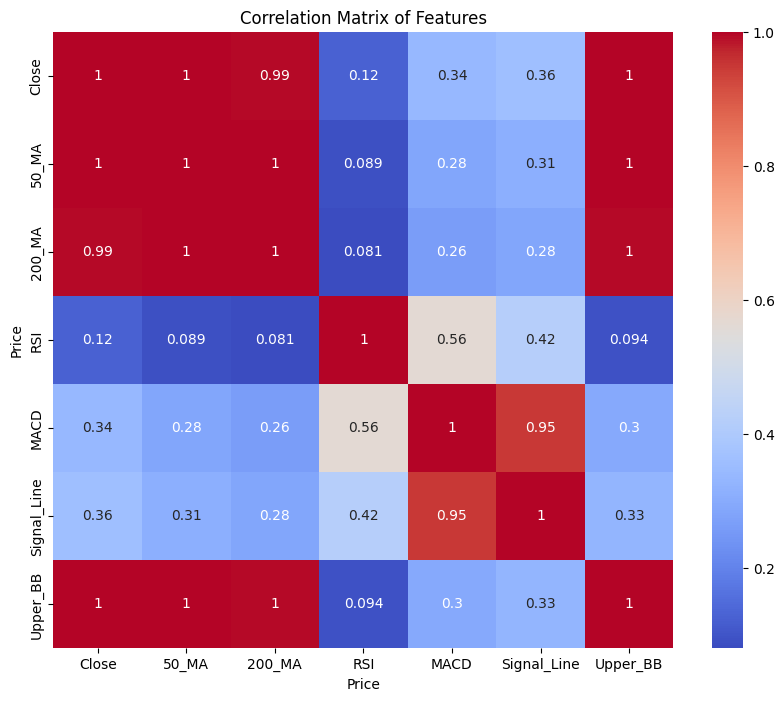

In [4]:
# Forward-fill monthly fundamentals to ensure daily continuity in the dataset.
feature_cols = ['Close', '50_MA', '200_MA', 'RSI', 'MACD', 'Signal_Line', 'Upper_BB']
corr_matrix = df_spy[feature_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Features")
plt.show()

In [5]:
df_spy[feature_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Price,,,,,,,,
Close,6289.0,181.407704,131.470098,50.379543,84.724037,110.717110,247.402039,603.954346
50_MA,6289.0,179.449484,128.886410,56.242991,84.402715,108.739142,244.430337,589.335564
200_MA,6289.0,173.891095,121.872850,58.125798,84.845810,106.108702,246.075327,548.682492
RSI,6289.0,55.365392,16.113578,0.000000,43.180161,55.742233,66.764854,99.065534
MACD,6289.0,0.557364,2.383148,-21.802720,-0.371022,0.530885,1.353620,9.030695
Signal_Line,6289.0,0.556516,2.230226,-18.247130,-0.329796,0.492622,1.294718,8.010340
Upper_BB,6289.0,186.370526,134.540523,56.634898,87.402626,113.050672,255.213261,610.994256


In [6]:
# Data Prep Function (Close-Only)
def prepare_spy_data_close_only(df, window_size=30):
    df = df.copy()
    df.dropna(subset=["Close"], inplace=True)
    
    # Compute log returns
    df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1)).fillna(0)
    # Extract features (just "Close") and target ("LogReturn")
    features = df[["Close"]].values  # shape: (num_samples, 1)
    target = df["LogReturn"].values.reshape(-1, 1)

    # Scale features & target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(features)
    scaled_target = target_scaler.fit_transform(target)

    # Build sequences of length 'window_size' to capture temporal dependencies
    # The target is the next day's (or multi-day) log return
    X, y = [], []
    for i in range(len(scaled_features) - window_size):
        X.append(scaled_features[i : i+window_size])
        y.append(scaled_target[i+window_size])
    X = np.array(X)  # shape: (samples, window_size, 1)
    y = np.array(y)  # shape: (samples, 1)
    
    return X, y, feature_scaler, target_scaler, df

In [7]:
# Build Model
def build_simple_lstm_model_v1(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=False),  # Single LSTM layer
        Dense(1)  # Single Dense output for log returns
    ])
    optimizer = Adam(learning_rate=0.0002)  # Lower initial LR
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [8]:
#Prepare Data
# df_spy is your DataFrame with a 'Close' column
X, y, feat_scaler, targ_scaler, df_spy_prepped = prepare_spy_data_close_only(df_spy, window_size=30)

print("X shape:", X.shape, "y shape:", y.shape)

X shape: (6259, 30, 1) y shape: (6259, 1)


In [9]:
#Split Data and Build Model

# Manually split (80% train, 20% test)
split_idx_v1 = int(len(X) * 0.8)
X_train_v1, X_test_v1 = X[:split_idx_v1], X[split_idx_v1:]
y_train_v1, y_test_v1 = y[:split_idx_v1], y[split_idx_v1:]

# Now define your input shape based on the shape of X_train
input_shape = (X_train_v1.shape[1], X_train_v1.shape[2])  

model_v1 = build_simple_lstm_model_v1(input_shape)
model_v1.summary()

2025-03-26 18:18:40.248240: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2025-03-26 18:18:40.248270: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-26 18:18:40.248275: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-26 18:18:40.248291: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-26 18:18:40.248300: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model_v1.fit(
    X_train_v1, y_train_v1,
    validation_data=(X_test_v1, y_test_v1),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/50


2025-03-26 18:18:40.552380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.9091 - val_loss: 1.1870 - learning_rate: 2.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8683 - val_loss: 1.1856 - learning_rate: 2.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9333 - val_loss: 1.1914 - learning_rate: 2.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8356 - val_loss: 1.1908 - learning_rate: 2.0000e-04
Epoch 5/50
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.9489
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9489 - val_loss: 1.1871 - learning_rate: 2.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8955 - val_loss: 1.1879 - learning_rate: 1.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9609 - val_loss: 1.1875 - learning_rate: 1.0000e-04
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8847 - val_l

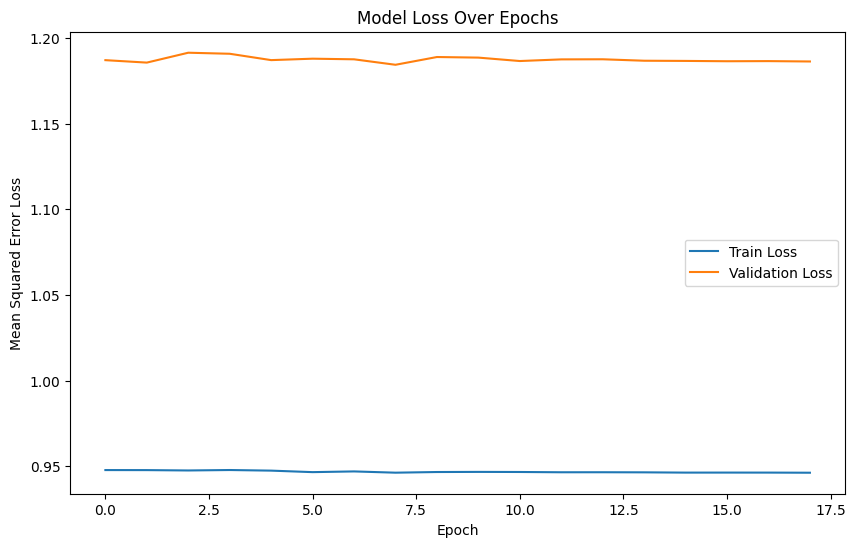

In [11]:
# Plot training & validation loss values
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.show()

In [12]:
pred_logreturns = model_v1.predict(X_test_v1)
actual_logreturns = y_test_v1

# Inverse transform to get back raw log returns
pred_logreturns_inv = targ_scaler.inverse_transform(pred_logreturns)
actual_logreturns_inv = targ_scaler.inverse_transform(actual_logreturns)

mse = mean_squared_error(actual_logreturns_inv, pred_logreturns_inv)
rmse = np.sqrt(mse)
print(f"RMSE on Log Returns: {rmse:.4f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE on Log Returns: 0.0133


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


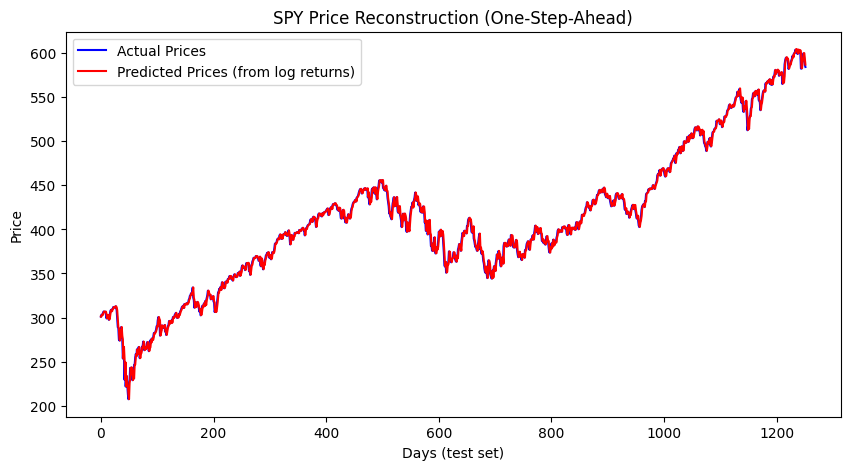

In [13]:
# I'll iterate through the test set day by day,
# always using the *actual* price from day t-1 to compute the day t price.

# I'll get the actual close prices from the DataFrame for the test portion:
window_size = 30
test_start_idx = split_idx_v1 + window_size  # The first day that X_test[0] corresponds to
actual_closes_test = df_spy_prepped["Close"].values[test_start_idx:]  # shape ~ (len(X_test),)

# Predict log returns for each sample in X_test:
pred_logreturns_scaled = model_v1.predict(X_test_v1)
pred_logreturns = targ_scaler.inverse_transform(pred_logreturns_scaled).flatten()

# Reconstruct prices *one-step-ahead*, using actual price from day t-1
reconstructed_prices = []
reconstructed_prices.append(actual_closes_test[0]) 

for i in range(1, len(pred_logreturns)):
    # predicted log return for day i
    r_t = pred_logreturns[i]
    # use the *actual* price from day i-1
    prev_price = actual_closes_test[i-1]
    new_price = prev_price * np.exp(r_t)
    reconstructed_prices.append(new_price)

reconstructed_prices = np.array(reconstructed_prices)

# Plot the result
plt.figure(figsize=(10,5))
plt.plot(actual_closes_test, label="Actual Prices", color="blue")
plt.plot(reconstructed_prices, label="Predicted Prices (from log returns)", color="red")
plt.title("SPY Price Reconstruction (One-Step-Ahead)")
plt.xlabel("Days (test set)")
plt.ylabel("Price")
plt.legend()
plt.show()

In [14]:
# Actual daily log returns for test portion
actual_logreturns_test = np.log(actual_closes_test[1:] / actual_closes_test[:-1])
# (One day shorter than the price array)

# Compare with pred_logreturns[1:] (since I used actual_closes_test[i-1] above)
rmse_log = np.sqrt(mean_squared_error(actual_logreturns_test, pred_logreturns[1:]))
print(f"One-step-ahead RMSE on Log Returns: {rmse_log:.4f}")

One-step-ahead RMSE on Log Returns: 0.0133


In [15]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import xgboost as xgb

In [16]:
# Baseline 1: Naive Baseline - Predict Zero Log Return
# (Since log returns are centered around zero, this is a common naive baseline)
naive_preds = np.zeros_like(actual_logreturns)  # actual_logreturns comes from targ_scaler.inverse_transform(y_test)
rmse_naive = sqrt(mean_squared_error(actual_logreturns, naive_preds))
print(f"Naive Baseline RMSE (predict 0): {rmse_naive:.4f}")

# Prepare features for simple models
# ---------------------------------------------------------
# For these simple baselines, we use the last value in each window.
# X_train and X_test are arrays of shape (samples, window_size, 1).
X_train_lr = X_train_v1[:, -1, 0].reshape(-1, 1)
X_test_lr = X_test_v1[:, -1, 0].reshape(-1, 1)

# Baseline 2: Linear Regression
lr = LinearRegression()
lr.fit(X_train_lr, y_train_v1)
lr_preds = lr.predict(X_test_lr)
lr_preds_inv = targ_scaler.inverse_transform(lr_preds)
actual_lr_inv = targ_scaler.inverse_transform(y_test_v1)
rmse_lr = sqrt(mean_squared_error(actual_lr_inv, lr_preds_inv))
print(f"Linear Regression Baseline RMSE: {rmse_lr:.4f}")

# Baseline 3: Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train_lr, y_train_v1.ravel())
rf_preds = rf.predict(X_test_lr)
rf_preds_inv = targ_scaler.inverse_transform(rf_preds.reshape(-1, 1))
rmse_rf = sqrt(mean_squared_error(actual_lr_inv, rf_preds_inv))
print(f"Random Forest Baseline RMSE: {rmse_rf:.4f}")

# Baseline 4: ARIMA Model
# For ARIMA, use the unscaled log return series from your prepared DataFrame.
# Assume df_spy_prepped is returned from your data preparation function.
log_returns = df_spy_prepped["LogReturn"].values  # unscaled log returns
# Align the train/test split with X: the first test sample corresponds to index = split_idx + window_size
arima_train = log_returns[window_size:split_idx_v1+window_size]
arima_test = log_returns[split_idx_v1+window_size:]
# Fit a simple ARIMA(1,0,0)
arima_model = sm.tsa.ARIMA(arima_train, order=(1, 0, 0))
arima_model_fit = arima_model.fit()
arima_preds = arima_model_fit.forecast(steps=len(arima_test))
rmse_arima = sqrt(mean_squared_error(arima_test, arima_preds))
print(f"ARIMA Baseline RMSE: {rmse_arima:.4f}")

# Baseline 5: XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train_lr, y_train_v1.ravel())
xgb_preds = xgb_model.predict(X_test_lr)
xgb_preds_inv = targ_scaler.inverse_transform(xgb_preds.reshape(-1, 1))
rmse_xgb = sqrt(mean_squared_error(actual_lr_inv, xgb_preds_inv))
print(f"XGBoost Baseline RMSE: {rmse_xgb:.4f}")

Naive Baseline RMSE (predict 0): 1.0883
Linear Regression Baseline RMSE: 0.0133
Random Forest Baseline RMSE: 0.0139
ARIMA Baseline RMSE: 0.0133
XGBoost Baseline RMSE: 0.0133


In [17]:
def prepare_spy_data_expanded(df, feature_cols, window_size=30):
    """
    Prepares SPY data for LSTM with an expanded feature set.
    Computes log returns as the target and scales both features and target.
    """
    df = df.copy()
    # Drop rows with missing values in the selected features and 'Close'
    df.dropna(subset=feature_cols + ['Close'], inplace=True)
    
    # Compute log returns as target
    df["LogReturn"] = np.log(df["Close"] / df["Close"].shift(1)).fillna(0)
    
    # Extract features and target
    features = df[feature_cols].values
    target = df["LogReturn"].values.reshape(-1, 1)
    
    # Scale features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(features)
    scaled_target = target_scaler.fit_transform(target)
    
    # Build sequences using a sliding window
    X, y = [], []
    for i in range(len(scaled_features) - window_size):
        X.append(scaled_features[i : i + window_size])
        y.append(scaled_target[i + window_size])
    X = np.array(X)
    y = np.array(y)
    
    return X, y, feature_scaler, target_scaler, df

In [18]:
# Add Volume Trends, ATR, and Stochastic Oscillator
def add_technical_indicators(df):
    """Adds technical indicators (including volume trends, ATR, and Stochastic Oscillator) to the stock DataFrame."""
    df = df.copy()
    # Flatten columns if they are MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df['Close'] = df['Close'].astype(float)

    # Moving Averages
    df['50_MA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200_MA'] = df['Close'].rolling(window=200, min_periods=1).mean()

    # RSI
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=14, min_periods=1).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14, min_periods=1).mean()
    rs = gain / (loss.replace(0, np.nan))
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI'] = df['RSI'].fillna(50)

    # Bollinger Bands
    df['20_MA'] = df['Close'].rolling(window=20, min_periods=1).mean()
    std_dev = df['Close'].rolling(window=20, min_periods=1).std(ddof=0)
    df['Upper_BB'] = df['20_MA'] + 2 * std_dev
    df['Lower_BB'] = df['20_MA'] - 2 * std_dev

    # MACD
    df['12_EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26_EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12_EMA'] - df['26_EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # Volume Trends
    df['Volume_MA'] = df['Volume'].rolling(window=20, min_periods=1).mean()
    df['Volume_Change'] = df['Volume'].pct_change().fillna(0)

    # ATR (Average True Range)
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = np.abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = np.abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    df['ATR'] = df['TR'].rolling(window=14, min_periods=1).mean()
    df.drop(['H-L', 'H-PC', 'L-PC', 'TR'], axis=1, inplace=True)

    # Stochastic Oscillator
    period = 14
    df['LowestLow'] = df['Low'].rolling(window=period, min_periods=1).min()
    df['HighestHigh'] = df['High'].rolling(window=period, min_periods=1).max()
    df['Stoch_%K'] = 100 * ((df['Close'] - df['LowestLow']) / (df['HighestHigh'] - df['LowestLow']))
    df['Stoch_%D'] = df['Stoch_%K'].rolling(window=3, min_periods=1).mean()
    df.drop(['LowestLow', 'HighestHigh'], axis=1, inplace=True)
    
    return df

[*********************100%***********************]  1 of 1 completed

Columns after adding indicators: ['Close', 'High', 'Low', 'Open', 'Volume', '50_MA', '200_MA', 'RSI', '20_MA', 'Upper_BB', 'Lower_BB', '12_EMA', '26_EMA', 'MACD', 'Signal_Line', 'Volume_MA', 'Volume_Change', 'ATR', 'Stoch_%K', 'Stoch_%D']
X shape: (6259, 30, 11) y shape: (6259, 1)
Input shape: (30, 11)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,451 (48.64 KB)

 Trainable params: 12,451 (48.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.9366 - val_loss: 1.2075 - learning_rate: 2.0000e-04
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9827 - val_loss: 1.2001 - learning_rate: 2.0000e-04
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9327 - val_loss: 1.1998 - learning_rate: 2.0000e-04
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9364 - val_loss: 1.2012 - learning_rate: 2.0000e-04
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9486 - val_loss: 1.2026 - learning_rate: 2.0000e-04
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9577 - val_loss: 1.1968 - learning_rate: 2.0000e-04
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8934 - val_loss: 1.2003 - learning_rate: 2.0000e-04
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9599 - val_loss: 1.2066 - learning_rate: 2.0000e-04
Epoch 9/50
311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.0020
Epoch 9: Redu

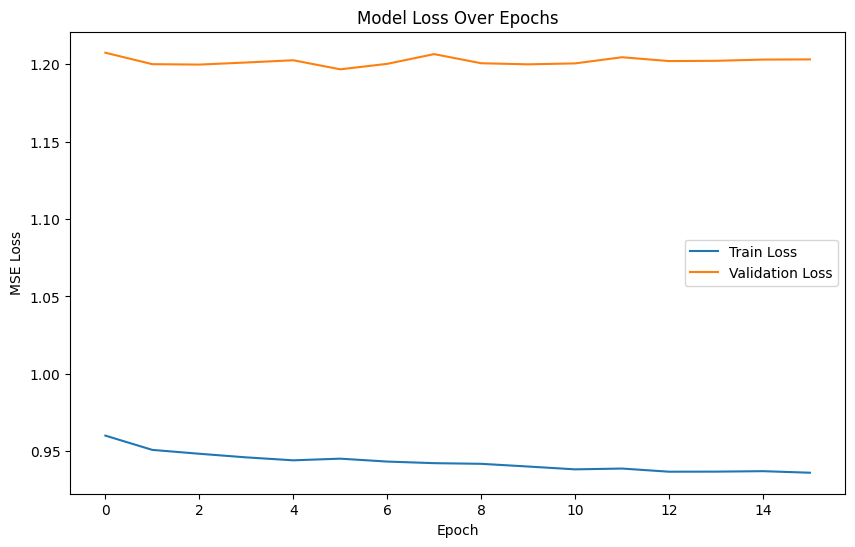

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  
RMSE on Log Returns: 0.0134


In [19]:
# Download and add indicators
ticker = "SPY"
start_date = "2000-01-01"
end_date = "2025-01-01"
df_spy = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
df_spy = add_technical_indicators(df_spy)
print("Columns after adding indicators:", df_spy.columns.tolist())

# Define your expanded feature columns
feature_cols = ['Close', 'Volume_MA', 'Volume_Change', 'ATR', 'Stoch_%K', 'Stoch_%D', 'RSI', 'MACD', 'Signal_Line', '50_MA', '200_MA']

# Prepare data with the expanded features
window_size = 30
X, y, feat_scaler, targ_scaler, df_spy_prepped = prepare_spy_data_expanded(df_spy, feature_cols, window_size=window_size)
print("X shape:", X.shape, "y shape:", y.shape)

# Split data into train/test sets (80/20 split)
split_idx_v2 = int(len(X) * 0.8)
X_train_v2, X_test_v2 = X[:split_idx_v2], X[split_idx_v2:]
y_train_v2, y_test_v2 = y[:split_idx_v2], y[split_idx_v2:]

# Define input shape based on training data
input_shape = (X_train_v2.shape[1], X_train_v2.shape[2])
print("Input shape:", input_shape)

# Build a simple LSTM model
def build_simple_lstm_model_v2(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model_v2 = build_simple_lstm_model_v2(input_shape)
model_v2.summary()

# Set up callbacks and train the model
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model_v2.fit(
    X_train_v2, y_train_v2,
    validation_data=(X_test_v2, y_test_v2),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot training history
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Evaluate RMSE on log returns
pred_logreturns = model_v2.predict(X_test_v2)
actual_logreturns = y_test_v2
pred_logreturns_inv = targ_scaler.inverse_transform(pred_logreturns)
actual_logreturns_inv = targ_scaler.inverse_transform(actual_logreturns)
rmse = np.sqrt(mean_squared_error(actual_logreturns_inv, pred_logreturns_inv))
print(f"RMSE on Log Returns: {rmse:.4f}")

In [20]:
#!/usr/bin/env python
# coding: utf-8
# stock_data-experiment.v3.py
# Version v3: Expanded features (volume, volatility, news, fundamental) with a multi-day forecast horizon.

# 1. IMPORT LIBRARIES
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [21]:
# 2. DOWNLOAD DATA (SPY)
ticker = "SPY"
start_date = "2000-01-01"
end_date = "2025-01-01"
df_spy = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
print("Raw SPY Data:\n", df_spy.head())

# Flatten columns if they're a MultiIndex, simplifying merging operations later
if isinstance(df_spy.columns, pd.MultiIndex):
    df_spy.columns = df_spy.columns.get_level_values(0)

# 3. SIMULATE ADDITIONAL DATA
# Simulate daily news sentiment (values between -1 and 1)
np.random.seed(42)
df_news = pd.DataFrame({
    'NewsSentiment': np.random.uniform(-1, 1, size=len(df_spy))
}, index=df_spy.index)

# Simulate monthly fundamental data: Inflation and Interest Rate
monthly_dates = pd.date_range(start=df_spy.index.min(), end=df_spy.index.max(), freq='MS')
df_fundamentals = pd.DataFrame({
    'Inflation': np.random.uniform(0.01, 0.05, size=len(monthly_dates)),
    'InterestRate': np.random.uniform(0.01, 0.05, size=len(monthly_dates))
}, index=monthly_dates)

# 4. MERGE ADDITIONAL DATA INTO STOCK DATA
# Merge news sentiment (daily)
df_spy = df_spy.merge(df_news, left_index=True, right_index=True, how='left')

# Merge fundamentals (monthly) and forward-fill to daily frequency
df_spy = df_spy.merge(df_fundamentals, left_index=True, right_index=True, how='left')
df_spy[['Inflation', 'InterestRate']] = df_spy[['Inflation', 'InterestRate']].fillna(method='ffill')

print("\nData with additional features:\n", df_spy.head())

[*********************100%***********************]  1 of 1 completed

Raw SPY Data:
 Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2000-01-03  92.414970  94.202110  91.422115  94.202110   8164300
2000-01-04  88.800926  91.541205  88.731426  91.203635   8089800
2000-01-05  88.959770  89.932768  87.212346  88.920056  12177900
2000-01-06  87.530083  89.912934  87.530083  88.721509   6227200
2000-01-07  92.613480  92.613480  88.999489  89.158346   8066500

Data with additional features:
                 Close       High        Low       Open    Volume  \
Date                                                               
2000-01-03  92.414970  94.202110  91.422115  94.202110   8164300   
2000-01-04  88.800926  91.541205  88.731426  91.203635   8089800   
2000-01-05  88.959770  89.932768  87.212346  88.920056  12177900   
2000-01-06  87.530083  89.912934  87.530083  88.721509   6227200   
2000-01-07  92.613480  9


/var/folders/6d/_fjbl5d54q93k6v0vk6fxhp40000gn/T/ipykernel_9814/729187945.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spy[['Inflation', 'InterestRate']] = df_spy[['Inflation', 'InterestRate']].fillna(method='ffill')



Columns after adding technical indicators:
 ['Close', 'High', 'Low', 'Open', 'Volume', 'NewsSentiment', 'Inflation', 'InterestRate', '50_MA', '200_MA', 'RSI', '20_MA', 'Upper_BB', 'Lower_BB', '12_EMA', '26_EMA', 'MACD', 'Signal_Line']


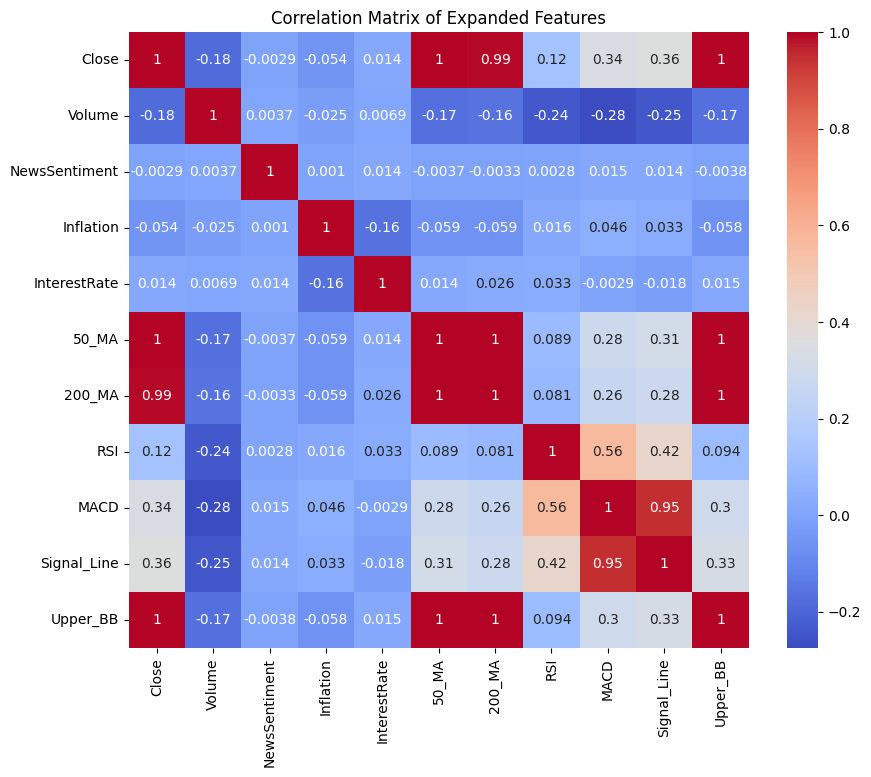

X shape: (6235, 30, 11) y shape: (6235, 1)
Input shape: (30, 11)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        12,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,451 (48.64 KB)

 Trainable params: 12,451 (48.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.9564 - val_loss: 1.2147 - learning_rate: 2.0000e-04
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9393 - val_loss: 1.2119 - learning_rate: 2.0000e-04
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0460 - val_loss: 1.2075 - learning_rate: 2.0000e-04
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8834 - val_loss: 1.2067 - learning_rate: 2.0000e-04
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8691 - val_loss: 1.2067 - learning_rate: 2.0000e-04
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9051 - val_loss: 1.2034 - learning_rate: 2.0000e-04
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.9169 - val_loss: 1.2168 - learning_rate: 2.0000e-04
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8890 - val_loss: 1.2284 - learning_rate: 2.0000e-04
Epoch 9/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8608
Epoch 9: Redu

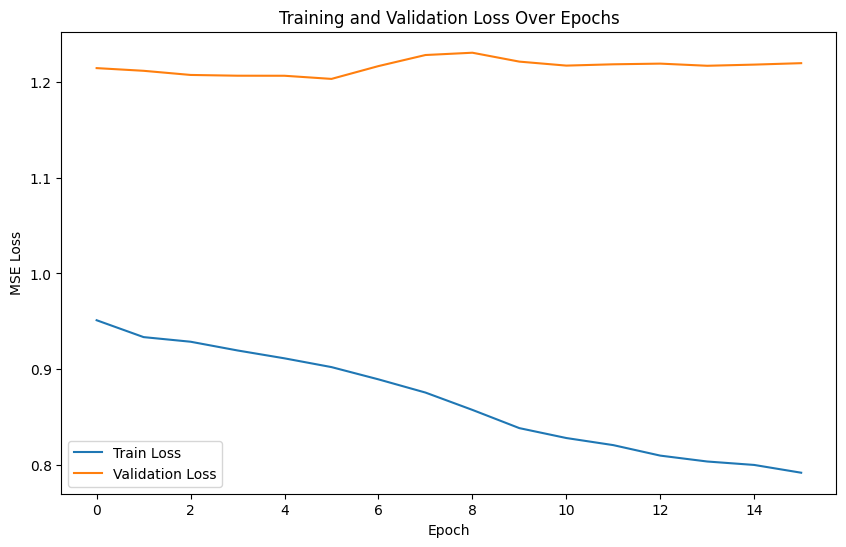

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE on 5-Day Log Returns: 0.0274
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


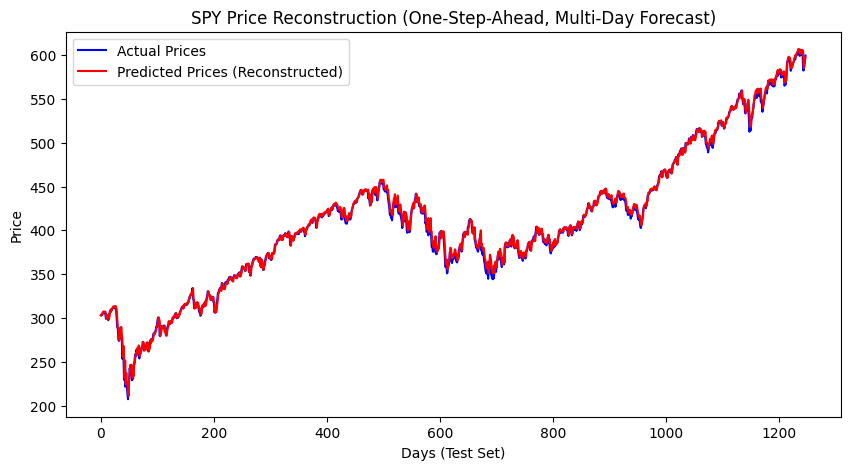

One-Step-Ahead RMSE on Log Returns: 0.0143


In [22]:
# 5. ADD TECHNICAL INDICATORS
def add_technical_indicators(df):
    """Adds technical indicators (moving averages, RSI, Bollinger Bands, MACD) to the DataFrame."""
    df = df.copy()
    # Flatten columns if MultiIndex
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df['Close'] = df['Close'].astype(float)
    
    # Moving Averages
    df['50_MA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200_MA'] = df['Close'].rolling(window=200, min_periods=1).mean()
    
    # RSI
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=14, min_periods=1).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14, min_periods=1).mean()
    rs = gain / (loss.replace(0, np.nan))
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI'] = df['RSI'].fillna(50)
    
    # Bollinger Bands
    df['20_MA'] = df['Close'].rolling(window=20, min_periods=1).mean()
    std_dev = df['Close'].rolling(window=20, min_periods=1).std(ddof=0)
    df['Upper_BB'] = df['20_MA'] + 2 * std_dev
    df['Lower_BB'] = df['20_MA'] - 2 * std_dev
    
    # MACD
    df['12_EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26_EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12_EMA'] - df['26_EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    return df

df_spy = add_technical_indicators(df_spy)
print("\nColumns after adding technical indicators:\n", df_spy.columns.tolist())

# 6. DEFINE EXPANDED FEATURE SET & VISUALIZE CORRELATIONS
feature_cols = [
    'Close', 'Volume', 'NewsSentiment', 'Inflation', 'InterestRate',
    '50_MA', '200_MA', 'RSI', 'MACD', 'Signal_Line', 'Upper_BB'
]
corr_matrix = df_spy[feature_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Expanded Features")
plt.show()

# 7. DATA PREPARATION FUNCTION WITH MULTI-DAY TARGET (Horizon)
def prepare_spy_data_expanded(df, feature_cols, window_size=30, horizon=5):
    """
    Prepares data with expanded features and a multi-day (horizon) target.
    The target is defined as the log return over the forecast horizon:
      log(P_{t+horizon} / P_t)
    """
    df = df.copy()
    # Drop rows with missing values in the selected features and 'Close'
    df.dropna(subset=feature_cols + ['Close'], inplace=True)
    
    # Compute multi-day log return as target
    df["TargetLogReturn"] = np.log(df["Close"].shift(-horizon) / df["Close"]).fillna(0)
    
    # Extract features and target
    features = df[feature_cols].values
    target = df["TargetLogReturn"].values.reshape(-1, 1)
    
    # Scale features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(features)
    scaled_target = target_scaler.fit_transform(target)
    
    # Build sequences using a sliding window
    X, y = [], []
    for i in range(len(scaled_features) - window_size - horizon + 1):
        X.append(scaled_features[i:i+window_size])
        y.append(scaled_target[i+window_size+horizon-1])
    X = np.array(X)
    y = np.array(y)
    
    return X, y, feature_scaler, target_scaler, df

# 8. PREPARE DATA USING THE EXPANDED FEATURE SET
window_size = 30
horizon = 5
X, y, feat_scaler, targ_scaler, df_spy_prepped = prepare_spy_data_expanded(df_spy, feature_cols, window_size=window_size, horizon=horizon)
print("X shape:", X.shape, "y shape:", y.shape)

# 9. SPLIT DATA AND BUILD THE MODEL
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

input_shape = (X_train.shape[1], X_train.shape[2])
print("Input shape:", input_shape)

def build_simple_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = build_simple_lstm_model(input_shape)
model.summary()

# 10. TRAIN THE MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# 11. EVALUATE MODEL: RMSE ON Multi-Day Log Returns
pred_logreturns = model.predict(X_test)
actual_logreturns = y_test
pred_logreturns_inv = targ_scaler.inverse_transform(pred_logreturns)
actual_logreturns_inv = targ_scaler.inverse_transform(actual_logreturns)
rmse = np.sqrt(mean_squared_error(actual_logreturns_inv, pred_logreturns_inv))
print(f"RMSE on {horizon}-Day Log Returns: {rmse:.4f}")

# 12. ONE-STEP-AHEAD PRICE RECONSTRUCTION (Using Multi-Day Forecasts)
# For reconstruction, I use the actual Close prices from the prepped DataFrame.
# The first test sample corresponds to index: split_idx + window_size in the prepped DataFrame.
test_start_idx = split_idx + window_size  
num_test_predictions = len(y_test)  # Number of predictions made

# Get exactly (num_test_predictions + 1) actual close prices for reconstruction
actual_closes_test = df_spy_prepped["Close"].values[test_start_idx : test_start_idx + num_test_predictions + 1]

# Predict multi-day log returns for each sample in X_test:
pred_logreturns_scaled = model.predict(X_test)
pred_logreturns = targ_scaler.inverse_transform(pred_logreturns_scaled).flatten()

# Reconstruct prices one-step-ahead using the actual previous day's price
reconstructed_prices = [actual_closes_test[0]]  # Start with the first actual price
for i in range(1, len(pred_logreturns)):
    r_t = pred_logreturns[i]
    prev_price = actual_closes_test[i-1]
    new_price = prev_price * np.exp(r_t)
    reconstructed_prices.append(new_price)
reconstructed_prices = np.array(reconstructed_prices)

plt.figure(figsize=(10,5))
plt.plot(actual_closes_test[:-1], label="Actual Prices", color="blue")
plt.plot(reconstructed_prices, label="Predicted Prices (Reconstructed)", color="red")
plt.title("SPY Price Reconstruction (One-Step-Ahead, Multi-Day Forecast)")
plt.xlabel("Days (Test Set)")
plt.ylabel("Price")
plt.legend()
plt.show()

# 13. CALCULATE ONE-STEP-AHEAD RMSE ON LOG RETURNS
# Compute the actual daily log returns from these actual close prices.
actual_logreturns_test = np.log(actual_closes_test[1:] / actual_closes_test[:-1])
# Ensure the predicted log returns for comparison match the length:
rmse_log = np.sqrt(mean_squared_error(actual_logreturns_test, pred_logreturns[:len(actual_logreturns_test)]))
print(f"One-Step-Ahead RMSE on Log Returns: {rmse_log:.4f}")

In [23]:
#!/usr/bin/env python
# coding: utf-8
# stock_data-experiment.v4.py
# Version v4: Expanded Feature Set for SPY with Additional Market Data

# 1. IMPORT LIBRARIES
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

[*********************100%***********************]  1 of 1 completed

Raw SPY Data:
 Price           Close       High        Low       Open    Volume
Ticker            SPY        SPY        SPY        SPY       SPY
Date                                                            
2000-01-03  92.414970  94.202110  91.422115  94.202110   8164300
2000-01-04  88.800926  91.541205  88.731426  91.203635   8089800
2000-01-05  88.959770  89.932768  87.212346  88.920056  12177900
2000-01-06  87.530083  89.912934  87.530083  88.721509   6227200
2000-01-07  92.613480  92.613480  88.999489  89.158346   8066500



[*********************100%***********************]  1 of 1 completed
/var/folders/6d/_fjbl5d54q93k6v0vk6fxhp40000gn/T/ipykernel_9814/442445476.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_spy[['Inflation', 'InterestRate']] = df_spy[['Inflation', 'InterestRate']].fillna(method='ffill')



Raw VIX Data:
 Price             VIX
Date                 
2000-01-03  24.209999
2000-01-04  27.010000
2000-01-05  26.410000
2000-01-06  25.730000
2000-01-07  21.719999

Data with additional features (news, fundamentals, VIX):
                 Close       High        Low       Open    Volume  \
Date                                                               
2000-01-03  92.414970  94.202110  91.422115  94.202110   8164300   
2000-01-04  88.800926  91.541205  88.731426  91.203635   8089800   
2000-01-05  88.959770  89.932768  87.212346  88.920056  12177900   
2000-01-06  87.530083  89.912934  87.530083  88.721509   6227200   
2000-01-07  92.613480  92.613480  88.999489  89.158346   8066500   

            NewsSentiment  Inflation  InterestRate        VIX  
Date                                                           
2000-01-03      -0.250920        NaN           NaN  24.209999  
2000-01-04       0.901429        NaN           NaN  27.010000  
2000-01-05       0.463988        NaN  

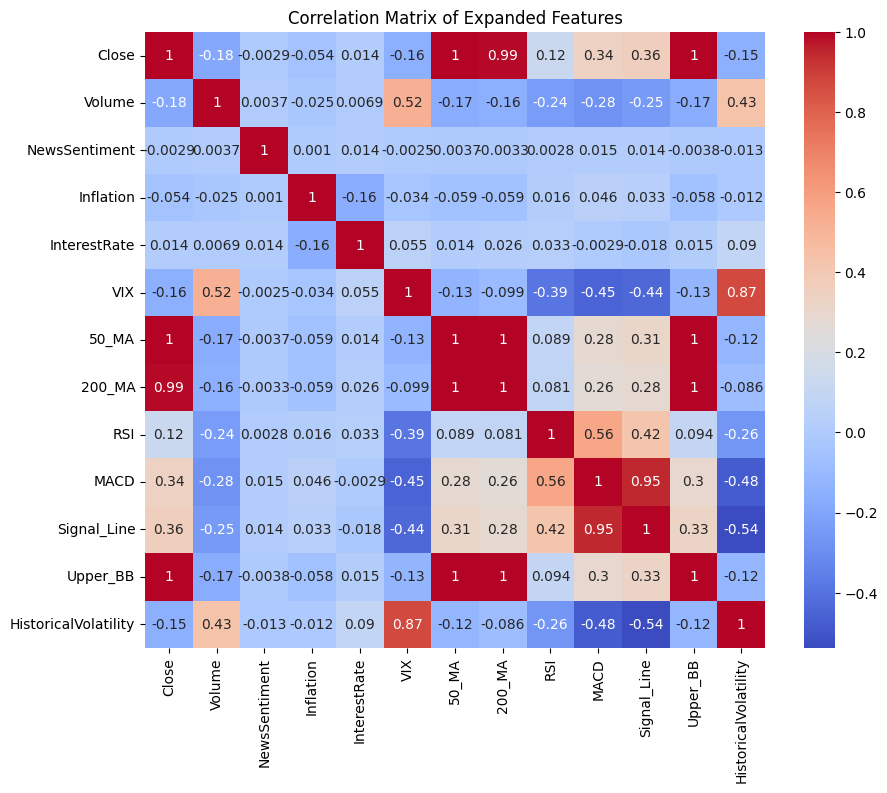

In [24]:
# 2. DOWNLOAD DATA FOR SPY AND VIX
ticker = "SPY"
start_date = "2000-01-01"
end_date = "2025-01-01"

# Download SPY data
df_spy = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
print("Raw SPY Data:\n", df_spy.head())

# Flatten columns if they're a MultiIndex
if isinstance(df_spy.columns, pd.MultiIndex):
    df_spy.columns = df_spy.columns.get_level_values(0)

# Download VIX data (broad market volatility)
df_vix = yf.download("^VIX", start=start_date, end=end_date, auto_adjust=True)
if isinstance(df_vix.columns, pd.MultiIndex):
    df_vix.columns = df_vix.columns.get_level_values(0)
df_vix = df_vix[['Close']].rename(columns={'Close': 'VIX'})
print("\nRaw VIX Data:\n", df_vix.head())

# 3. SIMULATE ADDITIONAL DATA (News & Fundamentals)
# Note: Simulated news sentiment and monthly fundamental data (inflation, interest rate) are 
# used to enrich the feature set, reflecting broader market influences on SPY.
# Simulate daily news sentiment (values between -1 and 1)
np.random.seed(42)
df_news = pd.DataFrame({
    'NewsSentiment': np.random.uniform(-1, 1, size=len(df_spy))
}, index=df_spy.index)

# Simulate monthly fundamental data: Inflation and Interest Rate
monthly_dates = pd.date_range(start=df_spy.index.min(), end=df_spy.index.max(), freq='MS')
df_fundamentals = pd.DataFrame({
    'Inflation': np.random.uniform(0.01, 0.05, size=len(monthly_dates)),
    'InterestRate': np.random.uniform(0.01, 0.05, size=len(monthly_dates))
}, index=monthly_dates)

# 4. MERGE ADDITIONAL DATA INTO STOCK DATA
# Merge news sentiment (daily)
df_spy = df_spy.merge(df_news, left_index=True, right_index=True, how='left')

# Merge fundamentals (monthly) and forward-fill to daily frequency
df_spy = df_spy.merge(df_fundamentals, left_index=True, right_index=True, how='left')
df_spy[['Inflation', 'InterestRate']] = df_spy[['Inflation', 'InterestRate']].fillna(method='ffill')

# Merge VIX data (daily)
df_spy = df_spy.merge(df_vix, left_index=True, right_index=True, how='left')
print("\nData with additional features (news, fundamentals, VIX):\n", df_spy.head())

# 5. ADD TECHNICAL INDICATORS & CALCULATE HISTORICAL VOLATILITY
def add_technical_indicators(df):
    """Adds technical indicators (moving averages, RSI, Bollinger Bands, MACD) and computes historical volatility."""
    df = df.copy()
    # Ensure single-level columns
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    
    df['Close'] = df['Close'].astype(float)
    
    # Moving Averages
    df['50_MA'] = df['Close'].rolling(window=50, min_periods=1).mean()
    df['200_MA'] = df['Close'].rolling(window=200, min_periods=1).mean()
    
    # RSI
    delta = df['Close'].diff(1)
    gain = delta.where(delta > 0, 0).rolling(window=14, min_periods=1).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14, min_periods=1).mean()
    rs = gain / (loss.replace(0, np.nan))
    df['RSI'] = 100 - (100 / (1 + rs))
    df['RSI'] = df['RSI'].fillna(50)
    
    # Bollinger Bands
    df['20_MA'] = df['Close'].rolling(window=20, min_periods=1).mean()
    std_dev = df['Close'].rolling(window=20, min_periods=1).std(ddof=0)
    df['Upper_BB'] = df['20_MA'] + 2 * std_dev
    df['Lower_BB'] = df['20_MA'] - 2 * std_dev
    
    # MACD
    df['12_EMA'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['26_EMA'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['12_EMA'] - df['26_EMA']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    
    # Historical Volatility: rolling standard deviation of daily log returns (20-day window)
    df['DailyLogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    df['HistoricalVolatility'] = df['DailyLogReturn'].rolling(window=20, min_periods=1).std() * np.sqrt(252)  # annualized
    df['HistoricalVolatility'] = df['HistoricalVolatility'].fillna(0)
    
    return df

df_spy = add_technical_indicators(df_spy)
print("\nColumns after adding technical indicators and historical volatility:\n", df_spy.columns.tolist())

# 6. DEFINE EXPANDED FEATURE SET & VISUALIZE CORRELATIONS
# Expanded feature set including all additional indicators:
feature_cols = [
    'Close', 'Volume', 'NewsSentiment', 'Inflation', 'InterestRate', 'VIX',
    '50_MA', '200_MA', 'RSI', 'MACD', 'Signal_Line', 'Upper_BB', 'HistoricalVolatility'
]

corr_matrix = df_spy[feature_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Expanded Features")
plt.show()

X shape: (6221, 30, 13) y shape: (6221, 1)
Input shape: (30, 13)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        12,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,851 (50.20 KB)

 Trainable params: 12,851 (50.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0048 - val_loss: 1.2120 - learning_rate: 2.0000e-04
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9591 - val_loss: 1.2147 - learning_rate: 2.0000e-04
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9719 - val_loss: 1.2169 - learning_rate: 2.0000e-04
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9219 
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9218 - val_loss: 1.2215 - learning_rate: 2.0000e-04
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.9385 - val_loss: 1.2139 - learning_rate: 1.0000e-04
Epoch 6/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8486 - val_loss: 1.2113 - learning_rate: 1.0000e-04
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.8998 - val_loss: 1.2087 - learning_rate: 1.0000e-04
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.8642 -

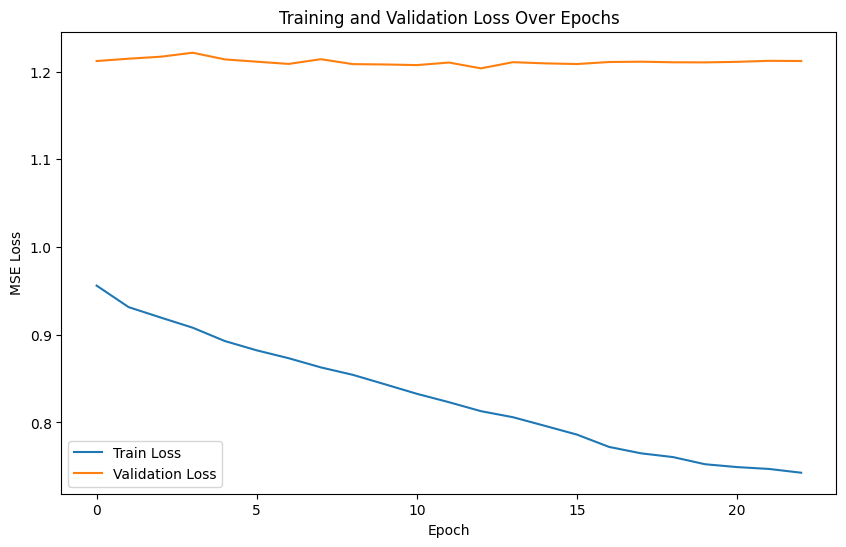

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE on 5-Day Log Returns: 0.0274
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


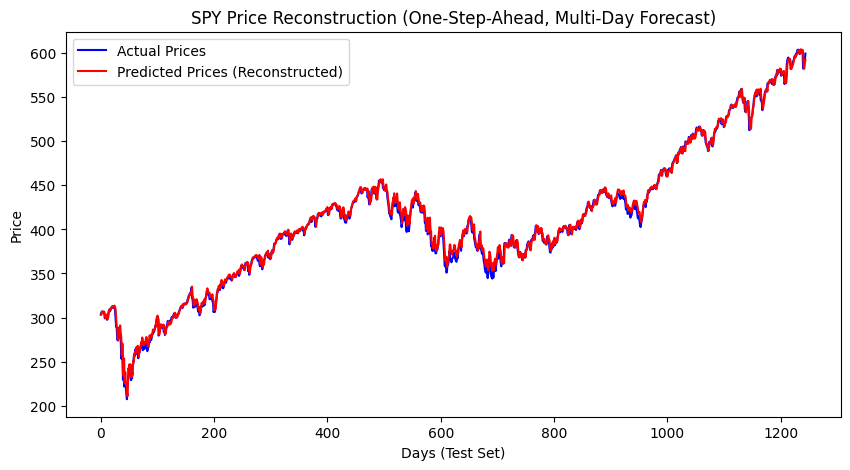

One-Step-Ahead RMSE on Log Returns: 0.0152


In [25]:
# 7. DATA PREPARATION FUNCTION WITH MULTI-DAY TARGET (Horizon)
def prepare_spy_data_expanded(df, feature_cols, window_size=30, horizon=5):
    """
    Prepares data with expanded features and a multi-day (horizon) target.
    The target is defined as the log return over the forecast horizon:
      log(P_{t+horizon} / P_t)
    """
    df = df.copy()
    # Remove the initial rows that may have incomplete rolling indicator calculations
    df = df.iloc[window_size + horizon - 1:]
    
    # Fill any remaining NaNs using forward fill as a safeguard
    df = df.ffill()
    
    # Now drop any remaining rows with missing values in the selected features and 'Close'
    df.dropna(subset=feature_cols + ['Close'], inplace=True)
    
    # Compute multi-day log return as target
    df["TargetLogReturn"] = np.log(df["Close"].shift(-horizon) / df["Close"]).fillna(0)
    
    # Extract features and target
    features = df[feature_cols].values
    target = df["TargetLogReturn"].values.reshape(-1, 1)
    
    # Scale features and target
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(features)
    scaled_target = target_scaler.fit_transform(target)
    
    # Build sequences using a sliding window
    X, y = [], []
    for i in range(len(scaled_features) - window_size - horizon + 1):
        X.append(scaled_features[i : i+window_size])
        y.append(scaled_target[i+window_size+horizon-1])
    X = np.array(X)
    y = np.array(y)
    
    return X, y, feature_scaler, target_scaler, df

# 8. PREPARE DATA USING THE EXPANDED FEATURE SET
window_size = 30
horizon = 5
X, y, feat_scaler, targ_scaler, df_spy_prepped = prepare_spy_data_expanded(df_spy, feature_cols, window_size=window_size, horizon=horizon)
print("X shape:", X.shape, "y shape:", y.shape)

# 9. SPLIT DATA AND BUILD THE MODEL
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

input_shape = (X_train.shape[1], X_train.shape[2])
print("Input shape:", input_shape)

def build_simple_lstm_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

model = build_simple_lstm_model(input_shape)
model.summary()

# 10. TRAIN THE MODEL
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# 11. EVALUATE MODEL: RMSE ON Multi-Day Log Returns
pred_logreturns = model.predict(X_test)
actual_logreturns = y_test
pred_logreturns_inv = targ_scaler.inverse_transform(pred_logreturns)
actual_logreturns_inv = targ_scaler.inverse_transform(actual_logreturns)
rmse = np.sqrt(mean_squared_error(actual_logreturns_inv, pred_logreturns_inv))
print(f"RMSE on {horizon}-Day Log Returns: {rmse:.4f}")

# 12. ONE-STEP-AHEAD PRICE RECONSTRUCTION (Using Multi-Day Forecasts)
# The first test sample corresponds to index: split_idx + window_size in df_spy_prepped.
test_start_idx = split_idx + window_size
num_test_predictions = len(y_test)  # Number of predictions
actual_closes_test = df_spy_prepped["Close"].values[test_start_idx : test_start_idx + num_test_predictions + 1]

# Predict multi-day log returns for each sample in X_test:
pred_logreturns_scaled = model.predict(X_test)
pred_logreturns = targ_scaler.inverse_transform(pred_logreturns_scaled).flatten()

# Reconstruct prices one-step-ahead using the actual previous day's price
reconstructed_prices = [actual_closes_test[0]]
for i in range(1, len(pred_logreturns)):
    r_t = pred_logreturns[i]
    prev_price = actual_closes_test[i-1]
    new_price = prev_price * np.exp(r_t)
    reconstructed_prices.append(new_price)
reconstructed_prices = np.array(reconstructed_prices)

plt.figure(figsize=(10,5))
plt.plot(actual_closes_test[:-1], label="Actual Prices", color="blue")
plt.plot(reconstructed_prices, label="Predicted Prices (Reconstructed)", color="red")
plt.title("SPY Price Reconstruction (One-Step-Ahead, Multi-Day Forecast)")
plt.xlabel("Days (Test Set)")
plt.ylabel("Price")
plt.legend()
plt.show()

# 13. CALCULATE ONE-STEP-AHEAD RMSE ON LOG RETURNS
actual_logreturns_test = np.log(actual_closes_test[1:] / actual_closes_test[:-1])
rmse_log = np.sqrt(mean_squared_error(actual_logreturns_test, pred_logreturns[:len(actual_logreturns_test)]))
print(f"One-Step-Ahead RMSE on Log Returns: {rmse_log:.4f}")

In [26]:
# Define the full expanded feature set
all_feature_cols = [
    'Close', 'Volume', 'NewsSentiment', 'Inflation', 'InterestRate', 'VIX',
    '50_MA', '200_MA', 'RSI', 'MACD', 'Signal_Line', 'Upper_BB', 'HistoricalVolatility'
]

# Dictionary to store RMSE results
ablation_results = {}

# Loop over each feature to test its impact
for feature in all_feature_cols:
    # Create a new feature set that excludes the current feature
    test_features = [f for f in all_feature_cols if f != feature]
    print(f"\nTesting without feature: {feature}")
    
    # Prepare data with the reduced feature set
    X_ablate, y_ablate, fs_ablate, ts_ablate, df_ablate = prepare_spy_data_expanded(
        df_spy, test_features, window_size=30, horizon=5
    )
    
    # Check if data was successfully prepared
    if X_ablate.shape[0] == 0:
        print(f"Skipping {feature} as the data becomes empty.")
        continue

    # Split the data (80% train, 20% test)
    split_idx = int(len(X_ablate) * 0.8)
    X_train_ab, X_test_ab = X_ablate[:split_idx], X_ablate[split_idx:]
    y_train_ab, y_test_ab = y_ablate[:split_idx], y_ablate[split_idx:]
    
    # Define the input shape and build the model
    input_shape_ab = (X_train_ab.shape[1], X_train_ab.shape[2])
    model_ablate = build_simple_lstm_model(input_shape_ab)
    
    # Train the model (suppress verbose output for brevity)
    history_ablate = model_ablate.fit(
        X_train_ab, y_train_ab,
        validation_data=(X_test_ab, y_test_ab),
        epochs=50,
        batch_size=16,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                   ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)],
        verbose=0
    )
    
    # Predict on test set and compute RMSE (on multi-day log returns)
    pred_ablate = model_ablate.predict(X_test_ab)
    # Inverse transform predictions and actual values
    pred_ablate_inv = ts_ablate.inverse_transform(pred_ablate)
    actual_ablate_inv = ts_ablate.inverse_transform(y_test_ab)
    
    rmse_ablate = np.sqrt(mean_squared_error(actual_ablate_inv, pred_ablate_inv))
    ablation_results[feature] = rmse_ablate
    print(f"RMSE without {feature}: {rmse_ablate:.4f}")

# Also, train a model with all features for reference
X_full, y_full, fs_full, ts_full, df_full = prepare_spy_data_expanded(df_spy, all_feature_cols, window_size=30, horizon=5)
split_idx_full = int(len(X_full) * 0.8)
X_train_full, X_test_full = X_full[:split_idx_full], X_full[split_idx_full:]
y_train_full, y_test_full = y_full[:split_idx_full], y_full[split_idx_full:]
input_shape_full = (X_train_full.shape[1], X_train_full.shape[2])
model_full = build_simple_lstm_model(input_shape_full)
history_full = model_full.fit(
    X_train_full, y_train_full,
    validation_data=(X_test_full, y_test_full),
    epochs=50,
    batch_size=16,
    callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
               ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)],
    verbose=0
)
pred_full = model_full.predict(X_test_full)
pred_full_inv = ts_full.inverse_transform(pred_full)
actual_full_inv = ts_full.inverse_transform(y_test_full)
rmse_full = np.sqrt(mean_squared_error(actual_full_inv, pred_full_inv))
print(f"\nRMSE with ALL features: {rmse_full:.4f}")

print("\nAblation Test Results:")
for feat, rmse_val in ablation_results.items():
    print(f"RMSE without {feat}: {rmse_val:.4f}")


Testing without feature: Close
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE without Close: 0.0276

Testing without feature: Volume
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE without Volume: 0.0276

Testing without feature: NewsSentiment
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE without NewsSentiment: 0.0274

Testing without feature: Inflation
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE without Inflation: 0.0276

Testing without feature: InterestRate
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE without InterestRate: 0.0273

Testing without feature: VIX
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step   
RMSE without VIX: 0.0277

Testing without feature: 50_MA
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE without 50_MA: 0.0275

Testing without feature: 200_MA
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE without 200_MA: 0.0275

Testing without feature: RSI
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RMSE without RSI: 0.0274

Testing without feature: MACD
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
RM

In [27]:
# Can confirm more technical indicators doesn't have enough of an impact on RMSE
# Testing respectably given the inherent noise in the data for daily return predictions
# Will try a more advanced architecture, although will only expect incremental improvements
def build_advanced_lstm_model(input_shape):
    # Define the input layer
    inputs = Input(shape=input_shape)
    
    # First LSTM layer (returning sequences)
    x = LSTM(64, return_sequences=True)(inputs)
    
    # Second LSTM layer (returning sequences)
    x = LSTM(32, return_sequences=True)(x)
    
    # Self-attention: using the built-in Attention layer
    # Here, both the queries and keys/values come from the output of the LSTM layers
    attention = tf.keras.layers.Attention()([x, x])
    
    # Pool the attention outputs over time
    x = tf.keras.layers.GlobalAveragePooling1D()(attention)
    
    # A Dense layer to learn further non-linearities
    x = Dense(32, activation='relu')(x)
    
    # Output layer (predicting the target log return)
    outputs = Dense(1)(x)
    
    # Build the model
    model = tf.keras.models.Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Example usage:
input_shape = (X_train.shape[1], X_train.shape[2])
advanced_model = build_advanced_lstm_model(input_shape)
advanced_model.summary()

# Train the model similarly:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

history_adv = advanced_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 30, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 30, 64)    │     19,968 │ input_layer_18[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 30, 32)    │     12,416 │ lstm_18[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 30, 32)    │          0 │ lstm_19[0][0],    │
│ (Attention)         │                   │            │ lstm_19[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 32)        │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 32)        │      1,056 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 1)         │         33 │ dense_18[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,473 (130.75 KB)

 Trainable params: 33,473 (130.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 0.9130 - val_loss: 1.2023 - learning_rate: 2.0000e-04
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.9204 - val_loss: 1.2031 - learning_rate: 2.0000e-04
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.9300 - val_loss: 1.1921 - learning_rate: 2.0000e-04
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.0200 - val_loss: 1.2042 - learning_rate: 2.0000e-04
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.8459 - val_loss: 1.1942 - learning_rate: 2.0000e-04
Epoch 6/50
309/311 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8406
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.8408 - val_loss: 1.2018 - learning_rate: 2.0000e-04
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.8024 - val_loss: 1.2071 - learning_rate: 1.0000e-04
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
RMSE on 5-Day Log Returns: 0.0272
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


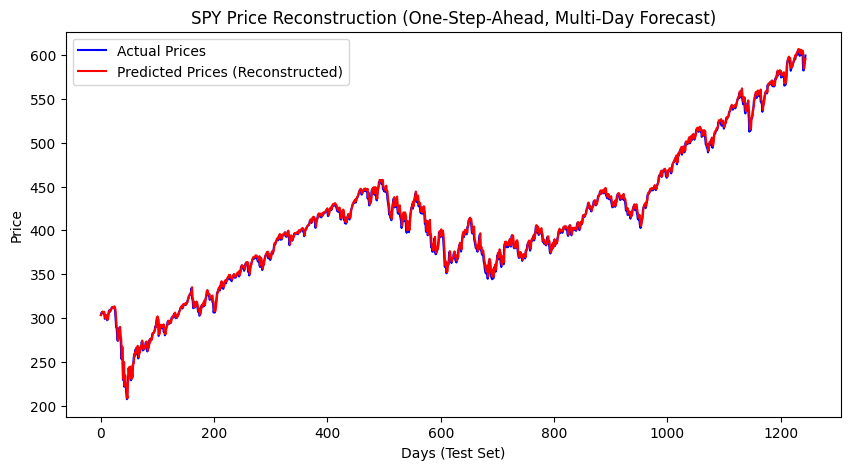

One-Step-Ahead RMSE on Log Returns: 0.0137


In [28]:
# Evaluate multi-day forecast performance on log returns
pred_logreturns = advanced_model.predict(X_test)  # Use advanced_model
actual_logreturns = y_test
pred_logreturns_inv = targ_scaler.inverse_transform(pred_logreturns)
actual_logreturns_inv = targ_scaler.inverse_transform(actual_logreturns)
rmse = np.sqrt(mean_squared_error(actual_logreturns_inv, pred_logreturns_inv))
print(f"RMSE on {horizon}-Day Log Returns: {rmse:.4f}")

# One-step-ahead price reconstruction evaluation:
test_start_idx = split_idx + window_size
num_test_predictions = len(y_test)  # Number of predictions
actual_closes_test = df_spy_prepped["Close"].values[test_start_idx : test_start_idx + num_test_predictions + 1]

pred_logreturns_scaled = advanced_model.predict(X_test)  # Again, using advanced_model here
pred_logreturns = targ_scaler.inverse_transform(pred_logreturns_scaled).flatten()

reconstructed_prices = [actual_closes_test[0]]  # Start with the first actual price
for i in range(1, len(pred_logreturns)):
    r_t = pred_logreturns[i]
    prev_price = actual_closes_test[i-1]
    new_price = prev_price * np.exp(r_t)
    reconstructed_prices.append(new_price)
reconstructed_prices = np.array(reconstructed_prices)

plt.figure(figsize=(10,5))
plt.plot(actual_closes_test[:-1], label="Actual Prices", color="blue")
plt.plot(reconstructed_prices, label="Predicted Prices (Reconstructed)", color="red")
plt.title("SPY Price Reconstruction (One-Step-Ahead, Multi-Day Forecast)")
plt.xlabel("Days (Test Set)")
plt.ylabel("Price")
plt.legend()
plt.show()

actual_logreturns_test = np.log(actual_closes_test[1:] / actual_closes_test[:-1])
rmse_log = np.sqrt(mean_squared_error(actual_logreturns_test, pred_logreturns[:len(actual_logreturns_test)]))
print(f"One-Step-Ahead RMSE on Log Returns: {rmse_log:.4f}")

In [29]:
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model

In [30]:
def build_transformer_model(input_shape, num_heads=2, ff_dim=32, dropout_rate=0.1):
    inputs = Input(shape=input_shape)
    
    # Transformer Encoder Block
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # Feed Forward Network (FFN)
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(input_shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    # Global pooling to convert the sequence into a single vector
    x = GlobalAveragePooling1D()(out2)
    outputs = Dense(1)(x)  # Predicting the target (multi-day log return)
    
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

# Build the transformer model using the same input_shape as before.
transformer_model = build_transformer_model(input_shape)
transformer_model.summary()

# Train the transformer model using your train/test splits and callbacks.
history_transformer = transformer_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_19      │ (None, 30, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 13)    │      1,443 │ input_layer_19[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 30, 13)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 30, 13)    │          0 │ input_layer_19[0… │
│                     │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 30, 13)    │         26 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_20 (Dense)    │ (None, 30, 32)    │        448 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 30, 13)    │        429 │ dense_20[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 13)    │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 13)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 13)    │         26 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 13)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │         14 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,386 (9.32 KB)

 Trainable params: 2,386 (9.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 1.4977 - val_loss: 1.2337 - learning_rate: 2.0000e-04
Epoch 2/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.9247 - val_loss: 1.2144 - learning_rate: 2.0000e-04
Epoch 3/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.9907 - val_loss: 1.1796 - learning_rate: 2.0000e-04
Epoch 4/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.8668 - val_loss: 1.2129 - learning_rate: 2.0000e-04
Epoch 5/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.9786 - val_loss: 1.2132 - learning_rate: 2.0000e-04
Epoch 6/50
310/311 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9735
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.9733 - val_loss: 1.1891 - learning_rate: 2.0000e-04
Epoch 7/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9557 - val_loss: 1.1990 - learning_rate: 1.0000e-04
Epoch 8/50
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0

In [31]:
# Compute RMSE on multi-day log returns:
pred_logreturns = transformer_model.predict(X_test)
actual_logreturns = y_test

# Inverse-transform the predictions and actual log returns to the original scale
pred_logreturns_inv = targ_scaler.inverse_transform(pred_logreturns)
actual_logreturns_inv = targ_scaler.inverse_transform(actual_logreturns)

rmse = np.sqrt(mean_squared_error(actual_logreturns_inv, pred_logreturns_inv))
print(f"Transformer Model RMSE on {horizon}-Day Log Returns: {rmse:.4f}")

# One-Step-Ahead Price Reconstruction
# The first test sample corresponds to index: split_idx + window_size in df_spy_prepped
test_start_idx = split_idx + window_size
num_test_predictions = len(y_test)  # Number of predictions
# Retrieve the corresponding actual close prices (need one extra for reconstruction)
actual_closes_test = df_spy_prepped["Close"].values[test_start_idx : test_start_idx + num_test_predictions + 1]

# Predict multi-day log returns for each sample in X_test (again)
pred_logreturns_scaled = transformer_model.predict(X_test)
# Inverse transform to get raw log returns
pred_logreturns = targ_scaler.inverse_transform(pred_logreturns_scaled).flatten()

# Reconstruct prices one-step-ahead using the actual previous day's price:
reconstructed_prices = [actual_closes_test[0]]  # Starting price (actual)
for i in range(1, len(pred_logreturns)):
    r_t = pred_logreturns[i]
    prev_price = actual_closes_test[i-1]
    new_price = prev_price * np.exp(r_t)
    reconstructed_prices.append(new_price)
reconstructed_prices = np.array(reconstructed_prices)

# Calculate One-Step-Ahead RMSE on Log Returns
# Compute the actual daily log returns from the actual close prices
actual_logreturns_test = np.log(actual_closes_test[1:] / actual_closes_test[:-1])
# Ensure the lengths match: use only as many predicted returns as actual ones
rmse_log = np.sqrt(mean_squared_error(actual_logreturns_test, pred_logreturns[:len(actual_logreturns_test)]))
print(f"One-Step-Ahead RMSE on Log Returns (Transformer): {rmse_log:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
Transformer Model RMSE on 5-Day Log Returns: 0.0271
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
One-Step-Ahead RMSE on Log Returns (Transformer): 0.0139


In [32]:
import itertools

def build_transformer_model(input_shape, num_heads=2, ff_dim=32, dropout_rate=0.1, learning_rate=0.0002):
    inputs = Input(shape=input_shape)
    # Transformer Encoder Block
    attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(input_shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    # Global pooling to convert the sequence into a single vector
    x = tf.keras.layers.GlobalAveragePooling1D()(out2)
    outputs = Dense(1)(x)  # Predicting the target (multi-day log return)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

# Hyperparameter grid
learning_rates = [0.0002, 0.0001]
dropout_rates = [0.1, 0.2]
num_heads_list = [2, 4]
ff_dims = [32, 64]

# Dictionary to store tuning results (parameter tuple -> best validation loss)
tuning_results = {}

for lr, dr, nh, ff in itertools.product(learning_rates, dropout_rates, num_heads_list, ff_dims):
    print(f"Testing: LR={lr}, Dropout={dr}, NumHeads={nh}, FF_Dim={ff}")
    model = build_transformer_model(input_shape, num_heads=nh, ff_dim=ff, dropout_rate=dr, learning_rate=lr)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=20,  # use fewer epochs for hyperparameter tuning
        batch_size=16,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=0)
        ],
        verbose=0
    )
    best_val_loss = min(history.history['val_loss'])
    tuning_results[(lr, dr, nh, ff)] = best_val_loss
    print(f"Best val_loss: {best_val_loss:.4f}")

# Sort and print the tuning results by validation loss (lowest first)
sorted_results = sorted(tuning_results.items(), key=lambda x: x[1])
print("\nHyperparameter Tuning Results:")
for params, loss in sorted_results:
    print(f"Params (LR, Dropout, NumHeads, FF_Dim): {params}, Best val_loss: {loss:.4f}")

Testing: LR=0.0002, Dropout=0.1, NumHeads=2, FF_Dim=32
Best val_loss: 1.2147
Testing: LR=0.0002, Dropout=0.1, NumHeads=2, FF_Dim=64
Best val_loss: 1.2393
Testing: LR=0.0002, Dropout=0.1, NumHeads=4, FF_Dim=32
Best val_loss: 1.2069
Testing: LR=0.0002, Dropout=0.1, NumHeads=4, FF_Dim=64
Best val_loss: 1.2397
Testing: LR=0.0002, Dropout=0.2, NumHeads=2, FF_Dim=32
Best val_loss: 1.2223
Testing: LR=0.0002, Dropout=0.2, NumHeads=2, FF_Dim=64
Best val_loss: 1.2199
Testing: LR=0.0002, Dropout=0.2, NumHeads=4, FF_Dim=32
Best val_loss: 1.2073
Testing: LR=0.0002, Dropout=0.2, NumHeads=4, FF_Dim=64
Best val_loss: 1.2251
Testing: LR=0.0001, Dropout=0.1, NumHeads=2, FF_Dim=32
Best val_loss: 1.2096
Testing: LR=0.0001, Dropout=0.1, NumHeads=2, FF_Dim=64
Best val_loss: 1.2098
Testing: LR=0.0001, Dropout=0.1, NumHeads=4, FF_Dim=32
Best val_loss: 1.1945
Testing: LR=0.0001, Dropout=0.1, NumHeads=4, FF_Dim=64
Best val_loss: 1.1950
Testing: LR=0.0001, Dropout=0.2, NumHeads=2, FF_Dim=32
Best val_loss: 1.2113

Model: "functional_36"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_36      │ (None, 30, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 13)    │      1,443 │ input_layer_36[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_36[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_52          │ (None, 30, 13)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 30, 13)    │          0 │ input_layer_36[0… │
│                     │                   │            │ dropout_52[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 13)    │         26 │ add_34[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_71 (Dense)    │ (None, 30, 32)    │        448 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_72 (Dense)    │ (None, 30, 13)    │        429 │ dense_71[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_53          │ (None, 30, 13)    │          0 │ dense_72[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_35 (Add)        │ (None, 30, 13)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_53[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 13)    │         26 │ add_35[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 13)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_73 (Dense)    │ (None, 1)         │         14 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,386 (9.32 KB)

 Trainable params: 2,386 (9.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 1.2119 - val_loss: 1.2468 - learning_rate: 2.0000e-04
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.9461 - val_loss: 1.2104 - learning_rate: 2.0000e-04
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.0050 - val_loss: 1.2186 - learning_rate: 2.0000e-04
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9486 - val_loss: 1.2280 - learning_rate: 2.0000e-04
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.9459 - val_loss: 1.2263 - learning_rate: 2.0000e-04
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.8946 - val_loss: 1.2338 - learning_rate: 2.0000e-04
Epoch 7/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.9463
Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9463 - val_loss: 1.2434 - learning_rate: 2.0000e-04
Epoch 8/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step -

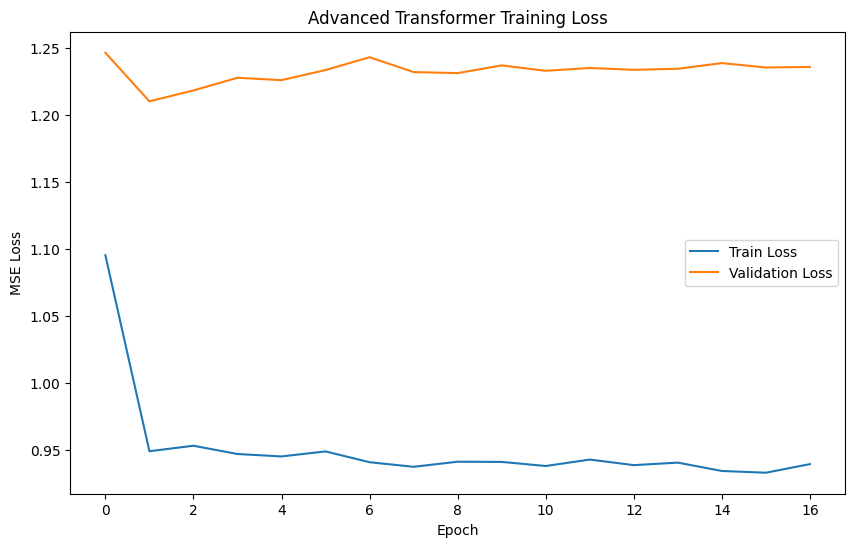

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step  
RMSE on 5-Day Log Returns (Advanced Transformer): 0.0274


In [33]:
# Use the best hyperparameters from your tuning:
best_lr = 0.0002
best_dropout = 0.2
best_num_heads = 2
best_ff_dim = 32

# Build the transformer-based model with the best configuration
def build_transformer_model(input_shape, num_heads, ff_dim, dropout_rate, learning_rate):
    inputs = Input(shape=input_shape)
    # Transformer Encoder Block
    attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    out1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # Feed-forward network
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(input_shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    # Global pooling to flatten sequence dimension
    x = tf.keras.layers.GlobalAveragePooling1D()(out2)
    outputs = Dense(1)(x)  # Predicting the target (multi-day log return)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

# Build the model using the best parameters
advanced_model = build_transformer_model(input_shape, 
                                         num_heads=best_num_heads, 
                                         ff_dim=best_ff_dim, 
                                         dropout_rate=best_dropout, 
                                         learning_rate=best_lr)
advanced_model.summary()

# Set up callbacks with increased patience for further fine-tuning
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train the model for a longer period (e.g., 100 epochs)
history_best = advanced_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Plot the training history for diagnostics
plt.figure(figsize=(10,6))
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Validation Loss')
plt.title('Advanced Transformer Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# Evaluate RMSE on multi-day log returns
pred_logreturns = advanced_model.predict(X_test)
actual_logreturns = y_test
pred_logreturns_inv = targ_scaler.inverse_transform(pred_logreturns)
actual_logreturns_inv = targ_scaler.inverse_transform(actual_logreturns)
rmse = np.sqrt(mean_squared_error(actual_logreturns_inv, pred_logreturns_inv))
print(f"RMSE on {horizon}-Day Log Returns (Advanced Transformer): {rmse:.4f}")

In [34]:
def prepare_spy_data_multi_horizon(df, feature_cols, window_size=30, horizons=[1,3,5]):
    """
    Prepares data with expanded features and multi-horizon targets.
    For each sample, the target is a vector containing the log return over each forecast horizon:
       [ log(P_{t+1}/P_t), log(P_{t+3}/P_t), log(P_{t+5}/P_t) ]
    
    Parameters:
      df: DataFrame with stock data and additional features.
      feature_cols: List of feature column names.
      window_size: Lookback window size.
      horizons: List of forecast horizons.
      
    Returns:
      X: array of shape (samples, window_size, num_features)
      y: array of shape (samples, len(horizons)) – multi-output targets
      feature_scaler, target_scaler, and the preprocessed DataFrame.
    """
    df = df.copy()
    # Remove early rows that might have incomplete rolling indicator calculations
    df = df.iloc[window_size + max(horizons) - 1:]
    df = df.ffill()  # Forward-fill any remaining NaNs
    df.dropna(subset=feature_cols + ['Close'], inplace=True)
    
    # For multi-horizon forecasting, compute log returns at each horizon (e.g. 1, 3, 5 days)
    for h in horizons:
        df[f"LogReturn_{h}d"] = np.log(df["Close"].shift(-h) / df["Close"]).fillna(0)
    
    # Define the target columns for multi-horizon forecasting
    target_cols = [f"LogReturn_{h}d" for h in horizons]
    
    # Extract features and multi-output target
    features = df[feature_cols].values            # shape: (num_samples, num_features)
    target = df[target_cols].values                 # shape: (num_samples, len(horizons))
    
    # Scale features and targets
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    scaled_features = feature_scaler.fit_transform(features)
    scaled_target = target_scaler.fit_transform(target)
    
    # Build sequences using a sliding window
    X, y = [], []
    # We need to stop at: len(scaled_features) - window_size - max(horizons) + 1
    for i in range(len(scaled_features) - window_size - max(horizons) + 1):
        X.append(scaled_features[i:i+window_size])
        # For each horizon, pick the target at the appropriate future index.
        # This creates a target vector for the sample.
        target_vector = []
        for h in horizons:
            target_vector.append(scaled_target[i+window_size+h-1][target_cols.index(f"LogReturn_{h}d")])
        y.append(target_vector)
    X = np.array(X)
    y = np.array(y)
    
    return X, y, feature_scaler, target_scaler, df

In [35]:
from tensorflow.keras.layers import Input, LayerNormalization, MultiHeadAttention, Dropout, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model

def build_transformer_multi_output_model(input_shape, num_heads=2, ff_dim=32, dropout_rate=0.1, learning_rate=0.0002, num_outputs=3):
    inputs = Input(shape=input_shape)
    
    # Transformer Encoder Block
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=input_shape[-1])(inputs, inputs)
    attention_output = Dropout(dropout_rate)(attention_output)
    out1 = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # Feed-forward network
    ffn_output = Dense(ff_dim, activation="relu")(out1)
    ffn_output = Dense(input_shape[-1])(ffn_output)
    ffn_output = Dropout(dropout_rate)(ffn_output)
    out2 = LayerNormalization(epsilon=1e-6)(out1 + ffn_output)
    
    # Global pooling to get fixed-length vector
    x = GlobalAveragePooling1D()(out2)
    
    # Output layer with multiple outputs (one for each horizon)
    outputs = Dense(num_outputs)(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="mean_squared_error")
    return model

# Example usage:
# Suppose our horizons list is [1,3,5], so num_outputs=3
num_outputs = 3
input_shape = (X_train.shape[1], X_train.shape[2])
transformer_multi_model = build_transformer_multi_output_model(input_shape, 
                                                               num_heads=best_num_heads, 
                                                               ff_dim=best_ff_dim, 
                                                               dropout_rate=best_dropout, 
                                                               learning_rate=best_lr,
                                                               num_outputs=num_outputs)
transformer_multi_model.summary()

Model: "functional_37"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 30, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 13)    │      1,443 │ input_layer_37[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_37[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 30, 13)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 30, 13)    │          0 │ input_layer_37[0… │
│                     │                   │            │ dropout_55[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 13)    │         26 │ add_36[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_74 (Dense)    │ (None, 30, 32)    │        448 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_75 (Dense)    │ (None, 30, 13)    │        429 │ dense_74[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 30, 13)    │          0 │ dense_75[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_37 (Add)        │ (None, 30, 13)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_56[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 13)    │         26 │ add_37[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 13)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_76 (Dense)    │ (None, 3)         │         42 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,414 (9.43 KB)

 Trainable params: 2,414 (9.43 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# Define your expanded feature set (example):
feature_cols = [
    'Close', 'Volume', 'NewsSentiment', 'Inflation', 'InterestRate', 'VIX',
    '50_MA', '200_MA', 'RSI', 'MACD', 'Signal_Line', 'Upper_BB', 'HistoricalVolatility'
]

# Set window size and forecast horizons:
window_size = 30
horizons = [1, 3, 5]

# Prepare data
X, y, feat_scaler, targ_scaler, df_spy_prepped = prepare_spy_data_multi_horizon(
    df_spy, feature_cols, window_size=window_size, horizons=horizons
)
print("X shape:", X.shape, "y shape:", y.shape)  # y should now have shape (samples, 3)

# Split data (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

input_shape = (X_train.shape[1], X_train.shape[2])
print("Input shape:", input_shape)

# Build your multi-output model (e.g., transformer model)
num_outputs = len(horizons)
transformer_multi_model = build_transformer_multi_output_model(input_shape, 
                                                               num_heads=best_num_heads, 
                                                               ff_dim=best_ff_dim, 
                                                               dropout_rate=best_dropout, 
                                                               learning_rate=best_lr,
                                                               num_outputs=num_outputs)
transformer_multi_model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

history_multi = transformer_multi_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

X shape: (6221, 30, 13) y shape: (6221, 3)
Input shape: (30, 13)


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38      │ (None, 30, 13)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 13)    │      1,443 │ input_layer_38[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_38[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 30, 13)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_38 (Add)        │ (None, 30, 13)    │          0 │ input_layer_38[0… │
│                     │                   │            │ dropout_58[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 13)    │         26 │ add_38[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_77 (Dense)    │ (None, 30, 32)    │        448 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_78 (Dense)    │ (None, 30, 13)    │        429 │ dense_77[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_59          │ (None, 30, 13)    │          0 │ dense_78[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_39 (Add)        │ (None, 30, 13)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_59[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 13)    │         26 │ add_39[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 13)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_79 (Dense)    │ (None, 3)         │         42 │ global_average_p… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,414 (9.43 KB)

 Trainable params: 2,414 (9.43 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 1.1399 - val_loss: 1.2479 - learning_rate: 2.0000e-04
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.9419 - val_loss: 1.2127 - learning_rate: 2.0000e-04
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9752 - val_loss: 1.1974 - learning_rate: 2.0000e-04
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9985 - val_loss: 1.2002 - learning_rate: 2.0000e-04
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9565 - val_loss: 1.1966 - learning_rate: 2.0000e-04
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9708 - val_loss: 1.2006 - learning_rate: 2.0000e-04
Epoch 7/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 1.0356 - val_loss: 1.1972 - learning_rate: 2.0000e-04
Epoch 8/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9568 - val_loss: 1.1957 - learning_rate: 2.0000e-04
Epoch 9/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.9768 - v

In [37]:
# Predict multi-horizon log returns
pred_multi = transformer_multi_model.predict(X_test)
# Inverse-transform predictions and actual values for each horizon.
# targ_scaler was fit on a multi-output target now, so it should return an array of shape (samples, num_outputs)
pred_multi_inv = targ_scaler.inverse_transform(pred_multi)
actual_multi_inv = targ_scaler.inverse_transform(y_test)

from sklearn.metrics import mean_squared_error
for idx, h in enumerate(horizons):
    rmse_h = np.sqrt(mean_squared_error(actual_multi_inv[:, idx], pred_multi_inv[:, idx]))
    print(f"RMSE on {h}-Day Log Returns: {rmse_h:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  
RMSE on 1-Day Log Returns: 0.0134
RMSE on 3-Day Log Returns: 0.0215
RMSE on 5-Day Log Returns: 0.0272


In [38]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU

def build_cnn_lstm_model(input_shape, num_outputs=3):
    """
    Builds a CNN-LSTM model for multi-horizon forecasting.
    The model applies a 1D convolution and pooling before passing data to an LSTM,
    and then outputs a vector of predictions.
    
    Parameters:
      input_shape: tuple, the shape of the input (window_size, num_features)
      num_outputs: int, number of forecast horizons
      
    Returns:
      A compiled Keras model.
    """
    model = Sequential()
    # Convolutional layer to extract local patterns
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    # LSTM layer to capture sequence dependencies
    model.add(LSTM(50, return_sequences=False))
    # Output layer with num_outputs units for multi-horizon predictions
    model.add(Dense(num_outputs))
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def build_gru_model(input_shape, num_outputs=3):
    """
    Builds a GRU-based model for multi-horizon forecasting.
    The model uses a GRU layer followed by a Dense output layer.
    
    Parameters:
      input_shape: tuple, the shape of the input (window_size, num_features)
      num_outputs: int, number of forecast horizons
      
    Returns:
      A compiled Keras model.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(50, return_sequences=False))
    model.add(Dense(num_outputs))
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Example usage:
# Assume X_train, horizons, etc. are defined from your data preparation.
input_shape = (X_train.shape[1], X_train.shape[2])  # e.g., (30, num_features)
num_outputs = len(horizons)  # e.g., if horizons = [1, 3, 5], then num_outputs = 3

cnn_lstm_model = build_cnn_lstm_model(input_shape, num_outputs=num_outputs)
gru_model = build_gru_model(input_shape, num_outputs=num_outputs)

print("CNN-LSTM Model Summary:")
cnn_lstm_model.summary()

print("\nGRU Model Summary:")
gru_model.summary()

CNN-LSTM Model Summary:


/Users/seanziogas/tf_env/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 28, 32)         │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 14, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,033 (70.44 KB)

 Trainable params: 18,033 (70.44 KB)

 Non-trainable params: 0 (0.00 B)


GRU Model Summary:


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 50)             │         9,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,903 (38.68 KB)

 Trainable params: 9,903 (38.68 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Train CNN-LSTM Model
print("Training CNN-LSTM model...")
history_cnn_lstm = cnn_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Train GRU Model
print("Training GRU model...")
history_gru = gru_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluate Models
# For evaluation, we assume that y_test and predictions are multi-output (one column per horizon)
# Inverse-transform the predictions and true targets to the original scale.
pred_cnn = cnn_lstm_model.predict(X_test)
pred_gru = gru_model.predict(X_test)

# Inverse transform (assuming targ_scaler was fit on the full multi-output target)
pred_cnn_inv = targ_scaler.inverse_transform(pred_cnn)
pred_gru_inv = targ_scaler.inverse_transform(pred_gru)
actual_inv = targ_scaler.inverse_transform(y_test)

# Compute RMSE for each horizon individually:
print("\nModel Performance (RMSE on Multi-Day Log Returns):")
for idx, h in enumerate(horizons):
    rmse_cnn = np.sqrt(mean_squared_error(actual_inv[:, idx], pred_cnn_inv[:, idx]))
    rmse_gru = np.sqrt(mean_squared_error(actual_inv[:, idx], pred_gru_inv[:, idx]))
    print(f"Horizon {h} day(s):")
    print(f"  CNN-LSTM RMSE: {rmse_cnn:.4f}")
    print(f"  GRU RMSE:      {rmse_gru:.4f}\n")

Training CNN-LSTM model...
Epoch 1/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.9590 - val_loss: 1.2137 - learning_rate: 2.0000e-04
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9230 - val_loss: 1.2035 - learning_rate: 2.0000e-04
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9293 - val_loss: 1.2072 - learning_rate: 2.0000e-04
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9559 - val_loss: 1.2074 - learning_rate: 2.0000e-04
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.8603 - val_loss: 1.2180 - learning_rate: 2.0000e-04
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0003 - val_loss: 1.2195 - learning_rate: 2.0000e-04
Epoch 7/100
308/311 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9253
Epoch 7: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-05.
311/311 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.9252 - val_loss: 1.2281 - learning_rate: 2.0000e-04
Epoch 8/100
311/311 ━━━━━━━━━━━━━━━━

In [40]:
# Additional Model Architectures (v7)
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.models import Model
# Import TCN from keras-tcn. If not installed, run: !pip install tcn
from tcn import TCN

def build_bidirectional_lstm_model(input_shape, num_outputs):
    """
    Builds a Bidirectional LSTM model for multi-horizon forecasting.
    
    Parameters:
      input_shape: tuple, e.g., (window_size, num_features)
      num_outputs: int, number of forecast horizons (e.g., 3 for [1,3,5]-day forecasts)
    
    Returns:
      A compiled Keras Sequential model.
    """
    model = Sequential([
        Input(shape=input_shape),
        Bidirectional(LSTM(50, return_sequences=False)),
        Dense(num_outputs)
    ])
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

def build_tcn_model(input_shape, num_outputs):
    """
    Builds a Temporal Convolutional Network (TCN) model for multi-horizon forecasting.
    
    Parameters:
      input_shape: tuple, e.g., (window_size, num_features)
      num_outputs: int, number of forecast horizons
    
    Returns:
      A compiled Keras Model using the TCN layer.
    """
    inputs = Input(shape=input_shape)
    # TCN layer: using default parameters here; you can tune filters, kernel_size, dilations, etc.
    x = TCN(return_sequences=False)(inputs)
    outputs = Dense(num_outputs)(x)
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=0.0002)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Example usage:
# Assume that your data preparation cell has already been run so that:
# - X_train, y_train, X_test, y_test are defined
# - input_shape = (window_size, num_features)
# - num_outputs = len(horizons) (e.g., 3 if horizons = [1,3,5])
print("Building Bidirectional LSTM model...")
bi_lstm_model = build_bidirectional_lstm_model(input_shape, num_outputs)
bi_lstm_model.summary()

print("\nBuilding TCN model...")
tcn_model = build_tcn_model(input_shape, num_outputs)
tcn_model.summary()

Building Bidirectional LSTM model...


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 100)            │        25,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 3)              │           303 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,903 (101.18 KB)

 Trainable params: 25,903 (101.18 KB)

 Non-trainable params: 0 (0.00 B)


Building TCN model...


Model: "functional_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_42 (InputLayer)     │ (None, 30, 13)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ tcn (TCN)                       │ (None, 64)             │       139,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,523 (545.01 KB)

 Trainable params: 139,523 (545.01 KB)

 Non-trainable params: 0 (0.00 B)

In [41]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

# Train Bidirectional LSTM model
history_bi_lstm = bi_lstm_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Train TCN model
history_tcn = tcn_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.9824 - val_loss: 1.2309 - learning_rate: 2.0000e-04
Epoch 2/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.9692 - val_loss: 1.2304 - learning_rate: 2.0000e-04
Epoch 3/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.9457 - val_loss: 1.2256 - learning_rate: 2.0000e-04
Epoch 4/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.9105 - val_loss: 1.2196 - learning_rate: 2.0000e-04
Epoch 5/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.9415 - val_loss: 1.2164 - learning_rate: 2.0000e-04
Epoch 6/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.9225 - val_loss: 1.2197 - learning_rate: 2.0000e-04
Epoch 7/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.9155 - val_loss: 1.2202 - learning_rate: 2.0000e-04
Epoch 8/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.8855 - val_loss: 1.2171 - learning_rate: 2.0000e-04
Epoch 9/100
311/311 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.8712 - v

In [42]:
# Create a dictionary of your trained models
model_dict = {
    "Transformer": transformer_multi_model,
    "CNN-LSTM": cnn_lstm_model,
    "GRU": gru_model,
    "Bidirectional LSTM": bi_lstm_model,
    "TCN": tcn_model
}

# Gather predictions from each model
predictions = {}
for name, model in model_dict.items():
    try:
        pred = model.predict(X_test)  # Expected shape: (samples, num_horizons)
        predictions[name] = pred
    except Exception as e:
        print(f"Error with model {name}: {e}")

# Inverse-transform the true targets for evaluation
actual_inv = targ_scaler.inverse_transform(y_test)

print("Individual Model Performance (RMSE on Log Returns):")
for name, pred in predictions.items():
    pred_inv = targ_scaler.inverse_transform(pred)
    print(f"\n{name}:")
    for idx, h in enumerate(horizons):
        rmse_val = np.sqrt(mean_squared_error(actual_inv[:, idx], pred_inv[:, idx]))
        print(f"  RMSE on {h}-day Log Returns: {rmse_val:.4f}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step 
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step  
Individual Model Performance (RMSE on Log Returns):

Transformer:
  RMSE on 1-day Log Returns: 0.0134
  RMSE on 3-day Log Returns: 0.0215
  RMSE on 5-day Log Returns: 0.0272

CNN-LSTM:
  RMSE on 1-day Log Returns: 0.0134
  RMSE on 3-day Log Returns: 0.0215
  RMSE on 5-day Log Returns: 0.0275

GRU:
  RMSE on 1-day Log Returns: 0.0134
  RMSE on 3-day Log Returns: 0.0218
  RMSE on 5-day Log Returns: 0.0274

Bidirectional LSTM:
  RMSE on 1-day Log Returns: 0.0134
  RMSE on 3-day Log Returns: 0.0217
  RMSE on 5-day Log Returns: 0.0277

TCN:
  RMSE on 1-day Log Returns: 0.0170
  RMSE on 3-day Log Returns: 0.0305
  RMSE on 5-day Log Returns: 0.0391


In [43]:
# Create ensemble predictions by averaging all model predictions
ensemble_pred = np.mean(np.array(list(predictions.values())), axis=0)
ensemble_pred_inv = targ_scaler.inverse_transform(ensemble_pred)

print("\nEnsemble Model Performance (RMSE on Log Returns):")
for idx, h in enumerate(horizons):
    rmse_ensemble = np.sqrt(mean_squared_error(actual_inv[:, idx], ensemble_pred_inv[:, idx]))
    print(f"  Ensemble RMSE on {h}-day Log Returns: {rmse_ensemble:.4f}")


Ensemble Model Performance (RMSE on Log Returns):
  Ensemble RMSE on 1-day Log Returns: 0.0135
  Ensemble RMSE on 3-day Log Returns: 0.0220
  Ensemble RMSE on 5-day Log Returns: 0.0280


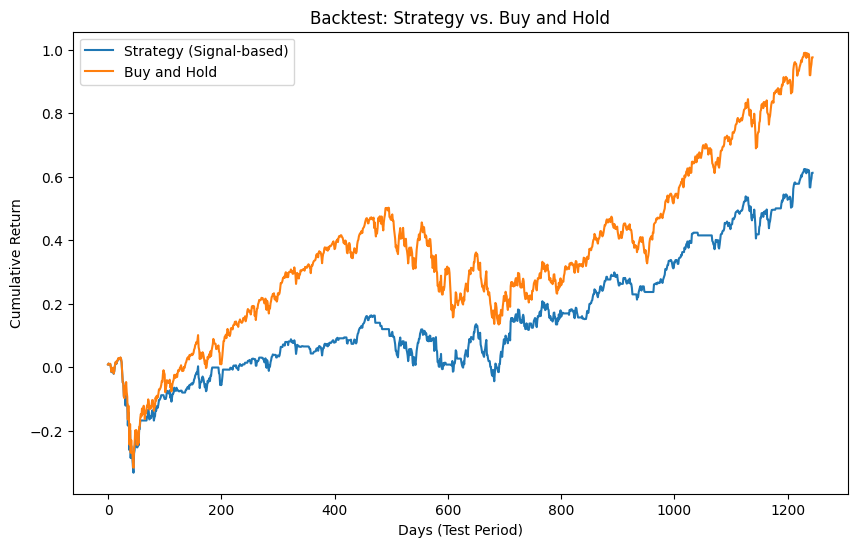

Final Strategy Return: 61.25%
Final Buy and Hold Return: 97.63%


In [44]:
# Backtesting: Generate Trading Signals & Evaluate Strategy

# Assume ensemble_pred_inv is an array of shape (n_samples, num_horizons)
# and use the first column for one-day forecasts.
# Also assume actual_closes_test is an array of actual close prices for the test period.

# Generate trading signal: if predicted one-day log return > 0, signal = 1 (go long); else 0 (stay in cash)
signal = np.where(ensemble_pred_inv[:, 0] > 0, 1, 0)

# Compute actual daily log returns from the test period
# actual_closes_test should have length = n_test + 1, so that differences produce n_test returns.
actual_log_returns = np.diff(np.log(actual_closes_test))  # shape: (n_test,)

# Align signal with actual returns (if signal is longer, truncate it)
signal = signal[:len(actual_log_returns)]

# Calculate strategy returns: when signal==1, you capture the actual log return; otherwise, zero return.
strategy_log_returns = signal * actual_log_returns

# Convert log returns to cumulative returns:
cumulative_strategy = np.exp(np.cumsum(strategy_log_returns)) - 1
cumulative_buy_hold = np.exp(np.cumsum(actual_log_returns)) - 1

# Plot the cumulative returns of the strategy vs. buy and hold
plt.figure(figsize=(10,6))
plt.plot(cumulative_strategy, label="Strategy (Signal-based)")
plt.plot(cumulative_buy_hold, label="Buy and Hold")
plt.title("Backtest: Strategy vs. Buy and Hold")
plt.xlabel("Days (Test Period)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

# Print final performance metrics
final_strategy_return = cumulative_strategy[-1]
final_buy_hold_return = cumulative_buy_hold[-1]
print(f"Final Strategy Return: {final_strategy_return:.2%}")
print(f"Final Buy and Hold Return: {final_buy_hold_return:.2%}")

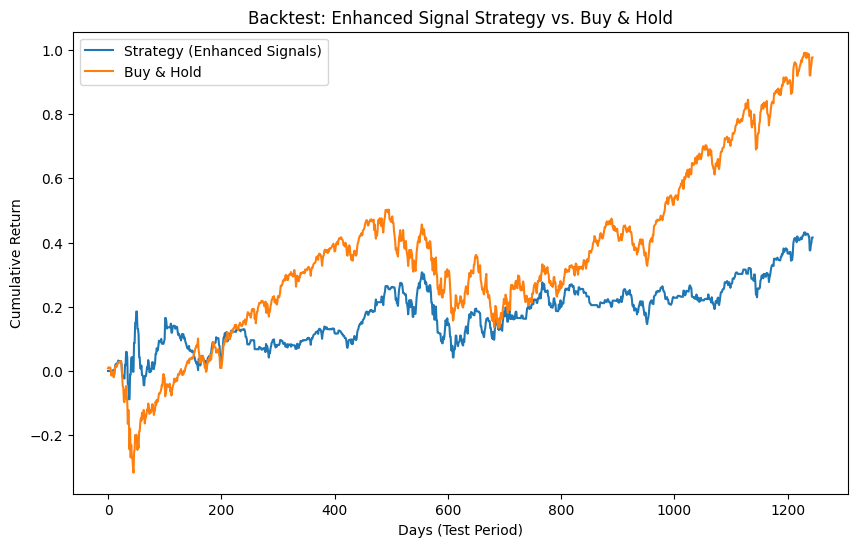

Final Strategy Return: 41.57%
Final Buy & Hold Return: 97.63%
Total Transaction Costs: 0.2115 (in log-return space equivalent)


In [45]:
# Example thresholds
threshold_pos = 0.001  # e.g., +0.1% predicted log return to go long
threshold_neg = -0.001 # e.g., -0.1% predicted log return to go short
stop_loss = -0.02      # e.g., if daily return < -2%, exit
take_profit =  0.03    # e.g., if daily return > +3%, exit
transaction_cost_rate = 0.0005  # 0.05% transaction cost each time we change position

# We'll combine 1-day and 3-day signals by taking an average of those columns
# ensemble_pred_inv shape: (n_samples, n_horizons)
# Let's say column 0 is 1-day log return, column 1 is 3-day log return
one_day_pred = ensemble_pred_inv[:, 0]
three_day_pred = ensemble_pred_inv[:, 1]
combined_signal = (one_day_pred + three_day_pred) / 2.0  # simple average

# Convert the predicted log returns to daily signals
#  +1 = long, -1 = short, 0 = cash
signals = np.zeros_like(combined_signal)
for i, val in enumerate(combined_signal):
    if val > threshold_pos:
        signals[i] = 1
    elif val < threshold_neg:
        signals[i] = -1
    else:
        signals[i] = 0

# Now compute actual daily log returns
actual_log_returns = np.diff(np.log(actual_closes_test))

# Ensure signals align with actual returns length
signals = signals[:len(actual_log_returns)]

# We'll track position day to day, applying stop-loss / take-profit checks
position = 0  # current position: +1 long, -1 short, 0 cash
strategy_log_returns = np.zeros_like(actual_log_returns)
cumulative_cost = 0.0

for i in range(len(actual_log_returns)):
    current_signal = signals[i]
    
    # If we are in a position, check for stop-loss / take-profit
    daily_return = actual_log_returns[i] * position
    if position != 0:
        if daily_return < stop_loss:   # stop-loss
            current_signal = 0
        elif daily_return > take_profit:  # take-profit
            current_signal = 0
    
    # Transaction cost if we change position
    if current_signal != position:
        # Deduct transaction cost from daily return
        # For simplicity, we assume cost is a fraction of the absolute position size
        cost = transaction_cost_rate
        cumulative_cost += cost
        # We effectively reduce daily return by cost if we changed position
        daily_return -= cost
    
    # Update the strategy return
    strategy_log_returns[i] = daily_return
    
    # Update position
    position = current_signal

# Convert log returns to cumulative returns
strategy_cumulative = np.exp(np.cumsum(strategy_log_returns)) - 1
buy_hold_cumulative = np.exp(np.cumsum(actual_log_returns)) - 1

final_strategy_return = strategy_cumulative[-1]
final_buy_hold_return = buy_hold_cumulative[-1]

# Plot the cumulative returns
plt.figure(figsize=(10,6))
plt.plot(strategy_cumulative, label="Strategy (Enhanced Signals)")
plt.plot(buy_hold_cumulative, label="Buy & Hold")
plt.title("Backtest: Enhanced Signal Strategy vs. Buy & Hold")
plt.xlabel("Days (Test Period)")
plt.ylabel("Cumulative Return")
plt.legend()
plt.show()

print(f"Final Strategy Return: {final_strategy_return:.2%}")
print(f"Final Buy & Hold Return: {final_buy_hold_return:.2%}")
print(f"Total Transaction Costs: {cumulative_cost:.4f} (in log-return space equivalent)")